## Environment Setup and Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyarrow
from matplotlib import pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pickle

## Order-Level Feature Functions

In [4]:
# =============================================================================
# 1. Order-Level Feature Extraction Functions as Referenced in the Paper
# =============================================================================
def bbo_moving_trade(df):
    df['bbo_moving_trade'] = np.where(((df['action'] == 'T') & (df['side'] == 'A') & (df['size'] >= df['bid_sz_00_minus'])) |
                                      ((df['action'] == 'T') & (df['side'] == 'B') & (df['size'] >= df['ask_sz_00_minus'])),
                                      1, 0)
    return df


def non_bbo_moving_trade(df):
    df['non_bbo_moving_trade'] = np.where(((df['action'] == 'T') & (df['side'] == 'A') & (df['size'] < df['bid_sz_00_minus'])) |
                                          ((df['action'] == 'T') & (df['side'] == 'B') & (df['size'] < df['ask_sz_00_minus'])),
                                          1, 0)
    return df


def bbo_improving_limit(df):
    df['bbo_improving_limit'] = np.where(((df['action'] == 'A') & (df['side'] == 'A') & (df['price'] < df['ask_px_00_minus'])) |
                                         ((df['action'] == 'A') & (df['side'] == 'B') & (df['price'] > df['bid_px_00_minus'])),
                                         1, 0)
    return df


def bbo_worsening_cancel(df):
    df['bbo_worsening_cancel'] = np.where(((df['action'] == 'C') & (df['side'] == 'A') & (df['price'] <= df['ask_px_00_minus']) &
                                                (df['size'] >= df['ask_sz_00_minus'])) |
                                          ((df['action'] == 'C') & (df['side'] == 'B') & (df['price'] >= df['bid_px_00_minus']) &
                                                (df['size'] >= df['bid_sz_00_minus'])),
                                          1, 0)
    return df

# =============================================================================
# 3. State-Level Feature Computation Functions
# =============================================================================

def bbo_depth_add_limit(df):
    df['bbo_depth_add_limit'] = np.where(((df['action'] == 'A') & (df['side'] == 'A') & (df['price'] == df['ask_px_00_minus'])) |
                                         ((df['action'] == 'A') & (df['side'] == 'B') & (df['price'] == df['bid_px_00_minus'])),
                                          1, 0)
    return df


def bbo_depth_remove_cancel(df):
    df['bbo_depth_remove_cancel'] = np.where(((df['action'] == 'C') & (df['side'] == 'A') & (df['price'] == df['ask_px_00_minus']) &
                                                (df['size'] < df['ask_sz_00_minus'])) |
                                             ((df['action'] == 'C') & (df['side'] == 'B') & (df['price'] == df['bid_px_00_minus']) &
                                                (df['size'] < df['bid_sz_00_minus'])),
                                             1, 0)
    return df


def non_bbo_depth_add_limit(df):
    df['non_bbo_depth_add_limit'] = np.where(((df['action'] == 'A') & (df['side'] == 'A') & (df['price'] > df['ask_px_00_minus']) &
                                              (df['price'] < df['ask_px_05_minus'])) |
                                             ((df['action'] == 'A') & (df['side'] == 'B') & (df['price'] < df['bid_px_00_minus']) &
                                              (df['price'] > df['bid_px_05_minus'])),
                                             1, 0)
    return df


def non_bbo_depth_remove_cancel(df):
    df['non_bbo_depth_remove_cancel'] = np.where(((df['action'] == 'C') & (df['side'] == 'A') & (df['price'] > df['ask_px_00_minus']) &
                                                  (df['price'] < df['ask_px_05_minus'])) |
                                                 ((df['action'] == 'C') & (df['side'] == 'B') & (df['price'] < df['bid_px_00_minus']) &
                                                  (df['price'] > df['bid_px_05_minus'])),
                                                 1, 0)
    return df


def non_bbo_deep_depth_add_limit(df):
    df['non_bbo_deep_depth_add_limit'] = np.where(((df['action'] == 'A') & (df['side'] == 'A') & (df['price'] >= df['ask_px_05_minus'])) |
                                                  ((df['action'] == 'A') & (df['side'] == 'B') & (df['price'] < df['bid_px_05_minus'])),
                                                  1, 0)
    return df


def non_bbo_deep_depth_remove_cancel(df):
    df['non_bbo_deep_depth_remove_cancel'] = np.where(((df['action'] == 'C') & (df['side'] == 'A') & (df['price'] > df['ask_px_05_minus'])) |
                                                 ((df['action'] == 'C') & (df['side'] == 'B') & (df['price'] < df['bid_px_05_minus'])),
                                                 1, 0)
    return df

# =============================================================================
# 4. Lagged Feature Engineering Functions
# =============================================================================

def lagged_ob_features(df):
    ob_features = ['bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
                   'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
                   'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 
                   'non_bbo_deep_depth_add_limit', 'non_bbo_deep_depth_remove_cancel']
    
    new_cols = {}
    for feat in ob_features:
        for r in range(1, 6):
            col_name = f'{feat}_{r}'
            new_cols[col_name] = df[feat].shift(1).rolling(r).sum().fillna(0)
    
    new_cols_df = pd.DataFrame(new_cols, index=df.index)
    df = pd.concat([df, new_cols_df], axis=1)
    
    return df


def add_ob_features(df):
    df = bbo_moving_trade(df)
    df = non_bbo_moving_trade(df)
    df = bbo_improving_limit(df)
    df = bbo_worsening_cancel(df)
    df = bbo_depth_add_limit(df)
    df = bbo_depth_remove_cancel(df)
    df = non_bbo_depth_add_limit(df)
    df = non_bbo_depth_remove_cancel(df)
    df = non_bbo_deep_depth_add_limit(df)
    df = non_bbo_deep_depth_remove_cancel(df)
    df = lagged_ob_features(df)

    return df

## State Feature Enhancement

In [5]:
# =============================================================================
# Functions to define state-level features used in the paper
# =============================================================================

def add_mid_px(df):
    df['mid_px_00'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    return df


def spread(df):
    df['spread'] = (df['ask_px_00'] - df['bid_px_00']) / df['mid_px_00']
    return df


def fill_missing(df):
    lvls = ['00', '01', '02', '03', '04', 
            '05', '06', '07', '08', '09']
    
    bid_fillers = [f'bid_sz_{i}' for i in lvls]
    ask_fillers = [f'ask_sz_{i}' for i in lvls]
    fillers = bid_fillers + ask_fillers

    df[fillers] = df[fillers].fillna(0)
    return df


def bbo_depth_imbalance(df):
    df['bbo_depth_imbalance'] = df['bid_sz_00'] - df['ask_sz_00']
    return df


def non_bbo_depth_imbalance(df):
    df['non_bbo_depth_imbalance'] = (df['bid_sz_00'] + df['bid_sz_01'] + df['bid_sz_02'] + df['bid_sz_03'] + df['bid_sz_04']) - \
                                    (df['ask_sz_00'] + df['ask_sz_01'] + df['ask_sz_02'] + df['ask_sz_03'] + df['ask_sz_04'])
    return df


def non_bbo_deep_depth_imbalance(df):
    df['non_bbo_deep_depth_imbalance'] = (df['bid_sz_05'] + df['bid_sz_06'] + df['bid_sz_07'] + df['bid_sz_08'] + df['bid_sz_09']) - \
                                         (df['ask_sz_05'] + df['ask_sz_06'] + df['ask_sz_07'] + df['ask_sz_08'] + df['ask_sz_09'])
    return df


def bbo_queue_length_immbalance(df):
    df['bbo_queue_length_immbalance'] = df['bid_ct_00'] - df['ask_ct_00']
    return df


def add_state_features(df):
    df = add_mid_px(df)
    df = spread(df)
    df = fill_missing(df)
    df = bbo_depth_imbalance(df)
    df = non_bbo_depth_imbalance(df)
    df = non_bbo_deep_depth_imbalance(df)
    df = bbo_queue_length_immbalance(df)
    return df

In [6]:
def add_px_impact(df):
    for i in [0, 1, 5, 10, 20]:
        if i == 0:
            df[f'px_imp_{i}'] = np.log(df['mid_px_00_plus'] / df['mid_px_00_minus']) * 1000
        else:
            df[f'px_imp_{i}'] = np.log(df['mid_px_00_plus'].shift(-i) / df['mid_px_00_minus']) * 1000
    
    return df

In [21]:
tickers = ['JPM', 'HPE', 'LNT', 'LULU', 'CCL', 'BBIO', 'NTNX', 'KO', 'NFE', 'MVST']

oct_train1 = ['01', '02', '03']
oct_val1 = ['04', '07', '08']

oct_train2 = ['09', '10', '11']
oct_val2 = ['14', '15', '16']

oct_train3 = ['17', '18', '21']
oct_val3 = ['22', '23', '24']

oct_train4 = ['25', '28', '29']
oct_val4 = ['30', '31']

nov_train5 = ['01', '04', '05']
nov_val5 = ['06', '07', '08']

nov_train6 = ['11', '12', '13']
nov_val6 = ['14', '15', '18']

nov_train7 = ['19', '20', '21']
nov_val7 = ['22', '25', '26']


In [5]:
df = pd.DataFrame()

for day in oct_train1:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/train_oct/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/train_oct/oct_train1_df.parquet')

JPM: 01
HPE: 01
LNT: 01
LULU: 01
CCL: 01
BBIO: 01
NTNX: 01
KO: 01
NFE: 01
MVST: 01
JPM: 02
HPE: 02
LNT: 02
LULU: 02
CCL: 02
BBIO: 02
NTNX: 02
KO: 02
NFE: 02
MVST: 02
JPM: 03
HPE: 03
LNT: 03
LULU: 03
CCL: 03
BBIO: 03
NTNX: 03
KO: 03
NFE: 03
MVST: 03


In [6]:
df = pd.DataFrame()

for day in oct_val1:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/train_oct/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/val_oct/oct_val1_df.parquet')

JPM: 04
HPE: 04
LNT: 04
LULU: 04
CCL: 04
BBIO: 04
NTNX: 04
KO: 04
NFE: 04
MVST: 04
JPM: 07
HPE: 07
LNT: 07
LULU: 07
CCL: 07
BBIO: 07
NTNX: 07
KO: 07
NFE: 07
MVST: 07
JPM: 08
HPE: 08
LNT: 08
LULU: 08
CCL: 08
BBIO: 08
NTNX: 08
KO: 08
NFE: 08
MVST: 08


In [7]:
df = pd.DataFrame()

for day in oct_train2:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/train_oct/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/train_oct/oct_train2_df.parquet')

JPM: 09
HPE: 09
LNT: 09
LULU: 09
CCL: 09
BBIO: 09
NTNX: 09
KO: 09
NFE: 09
MVST: 09
JPM: 10
HPE: 10
LNT: 10
LULU: 10
CCL: 10
BBIO: 10
NTNX: 10
KO: 10
NFE: 10
MVST: 10
JPM: 11
HPE: 11
LNT: 11
LULU: 11
CCL: 11
BBIO: 11
NTNX: 11
KO: 11
NFE: 11
MVST: 11


In [8]:
df = pd.DataFrame()

for day in oct_val2:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/train_oct/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/val_oct/oct_val2_df.parquet')

JPM: 14
HPE: 14
LNT: 14
LULU: 14
CCL: 14
BBIO: 14
NTNX: 14
KO: 14
NFE: 14
MVST: 14
JPM: 15
HPE: 15
LNT: 15
LULU: 15
CCL: 15
BBIO: 15
NTNX: 15
KO: 15
NFE: 15
MVST: 15
JPM: 16
HPE: 16
LNT: 16
LULU: 16
CCL: 16
BBIO: 16
NTNX: 16
KO: 16
NFE: 16
MVST: 16


In [9]:
df = pd.DataFrame()

for day in oct_train3:
    if day == '21':
        folder = 'val_oct'
    else:
        folder = 'train_oct'
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/{folder}/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/train_oct/oct_train3_df.parquet')

JPM: 17
HPE: 17
LNT: 17
LULU: 17
CCL: 17
BBIO: 17
NTNX: 17
KO: 17
NFE: 17
MVST: 17
JPM: 18
HPE: 18
LNT: 18
LULU: 18
CCL: 18
BBIO: 18
NTNX: 18
KO: 18
NFE: 18
MVST: 18
JPM: 21
HPE: 21
LNT: 21
LULU: 21
CCL: 21
BBIO: 21
NTNX: 21
KO: 21
NFE: 21
MVST: 21


In [10]:
df = pd.DataFrame()

for day in oct_val3:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/val_oct/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/val_oct/oct_val3_df.parquet')

JPM: 22
HPE: 22
LNT: 22
LULU: 22
CCL: 22
BBIO: 22
NTNX: 22
KO: 22
NFE: 22
MVST: 22
JPM: 23
HPE: 23
LNT: 23
LULU: 23
CCL: 23
BBIO: 23
NTNX: 23
KO: 23
NFE: 23
MVST: 23
JPM: 24
HPE: 24
LNT: 24
LULU: 24
CCL: 24
BBIO: 24
NTNX: 24
KO: 24
NFE: 24
MVST: 24


In [11]:
df = pd.DataFrame()

for day in oct_train4:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/val_oct/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/train_oct/oct_train4_df.parquet')

JPM: 25
HPE: 25
LNT: 25
LULU: 25
CCL: 25
BBIO: 25
NTNX: 25
KO: 25
NFE: 25
MVST: 25
JPM: 28
HPE: 28
LNT: 28
LULU: 28
CCL: 28
BBIO: 28
NTNX: 28
KO: 28
NFE: 28
MVST: 28
JPM: 29
HPE: 29
LNT: 29
LULU: 29
CCL: 29
BBIO: 29
NTNX: 29
KO: 29
NFE: 29
MVST: 29


In [12]:
df = pd.DataFrame()

for day in oct_val4:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/val_oct/{tick}/{tick}-202410{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/val_oct/oct_val4_df.parquet')

JPM: 30
HPE: 30
LNT: 30
LULU: 30
CCL: 30
BBIO: 30
NTNX: 30
KO: 30
NFE: 30
MVST: 30
JPM: 31
HPE: 31
LNT: 31
LULU: 31
CCL: 31
BBIO: 31
NTNX: 31
KO: 31
NFE: 31
MVST: 31


In [15]:
df = pd.DataFrame()

for day in nov_train5:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/train_nov/{tick}/{tick}-202411{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/train_nov/nov_train5_df.parquet')

JPM: 01
HPE: 01
LNT: 01
LULU: 01
CCL: 01
BBIO: 01
NTNX: 01
KO: 01
NFE: 01
MVST: 01
JPM: 04
HPE: 04
LNT: 04
LULU: 04
CCL: 04
BBIO: 04
NTNX: 04
KO: 04
NFE: 04
MVST: 04
JPM: 05
HPE: 05
LNT: 05
LULU: 05
CCL: 05
BBIO: 05
NTNX: 05
KO: 05
NFE: 05
MVST: 05


In [16]:
df = pd.DataFrame()

for day in nov_val5:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/train_nov/{tick}/{tick}-202411{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/val_nov/nov_val5_df.parquet')

JPM: 06
HPE: 06
LNT: 06
LULU: 06
CCL: 06
BBIO: 06
NTNX: 06
KO: 06
NFE: 06
MVST: 06
JPM: 07
HPE: 07
LNT: 07
LULU: 07
CCL: 07
BBIO: 07
NTNX: 07
KO: 07
NFE: 07
MVST: 07
JPM: 08
HPE: 08
LNT: 08
LULU: 08
CCL: 08
BBIO: 08
NTNX: 08
KO: 08
NFE: 08
MVST: 08


In [17]:
df = pd.DataFrame()

for day in nov_train6:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/train_nov/{tick}/{tick}-202411{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/train_nov/nov_train6_df.parquet')

JPM: 11
HPE: 11
LNT: 11
LULU: 11
CCL: 11
BBIO: 11
NTNX: 11
KO: 11
NFE: 11
MVST: 11
JPM: 12
HPE: 12
LNT: 12
LULU: 12
CCL: 12
BBIO: 12
NTNX: 12
KO: 12
NFE: 12
MVST: 12
JPM: 13
HPE: 13
LNT: 13
LULU: 13
CCL: 13
BBIO: 13
NTNX: 13
KO: 13
NFE: 13
MVST: 13


In [18]:
df = pd.DataFrame()

for day in nov_val6:
    if day == '18':
        folder = 'val_nov'
    else:
        folder = 'train_nov'
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/{folder}/{tick}/{tick}-202411{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/val_nov/nov_val6_df.parquet')

JPM: 14
HPE: 14
LNT: 14
LULU: 14
CCL: 14
BBIO: 14
NTNX: 14
KO: 14
NFE: 14
MVST: 14
JPM: 15
HPE: 15
LNT: 15
LULU: 15
CCL: 15
BBIO: 15
NTNX: 15
KO: 15
NFE: 15
MVST: 15
JPM: 18
HPE: 18
LNT: 18
LULU: 18
CCL: 18
BBIO: 18
NTNX: 18
KO: 18
NFE: 18
MVST: 18


In [19]:
df = pd.DataFrame()

for day in nov_train7:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/val_nov/{tick}/{tick}-202411{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/train_nov/nov_train7_df.parquet')

JPM: 19
HPE: 19
LNT: 19
LULU: 19
CCL: 19
BBIO: 19
NTNX: 19
KO: 19
NFE: 19
MVST: 19
JPM: 20
HPE: 20
LNT: 20
LULU: 20
CCL: 20
BBIO: 20
NTNX: 20
KO: 20
NFE: 20
MVST: 20
JPM: 21
HPE: 21
LNT: 21
LULU: 21
CCL: 21
BBIO: 21
NTNX: 21
KO: 21
NFE: 21
MVST: 21


In [22]:
df = pd.DataFrame()

for day in nov_val7:
    for tick in tickers:
        print(f'{tick}: {day}')
        temp = pd.read_parquet(f'/data/workspace_files/val_nov/{tick}/{tick}-202411{day}-df.parquet')
        df = pd.concat([df, temp])
    
df.to_parquet('/data/workspace_files/val_nov/nov_val7_df.parquet')

JPM: 22
HPE: 22
LNT: 22
LULU: 22
CCL: 22
BBIO: 22
NTNX: 22
KO: 22
NFE: 22
MVST: 22
JPM: 25
HPE: 25
LNT: 25
LULU: 25
CCL: 25
BBIO: 25
NTNX: 25
KO: 25
NFE: 25
MVST: 25
JPM: 26
HPE: 26
LNT: 26
LULU: 26
CCL: 26
BBIO: 26
NTNX: 26
KO: 26
NFE: 26
MVST: 26


### VAR Model Analysis and Impulse Response Functions (IRF)

Impulse response values:
 [[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  1.00000000e+00]]

 [[ 2.61554698e-01  4.80149676e-07  4.83331369e-08 ...  2.14296480e-07
    2.72568909e-07  1.83952224e-07]
  [ 5.78183727e+00  9.45110740e-02  5.93444326e-02 ...  5.00485665e-03
    5.64163271e-03  4.86967803e-03]
  [ 5.76176984e-01  4.23515305e-02  1.70778843e-01 ...  6.61583568e-03
    6.64438517e-03  4.93293306e-03]
  .

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


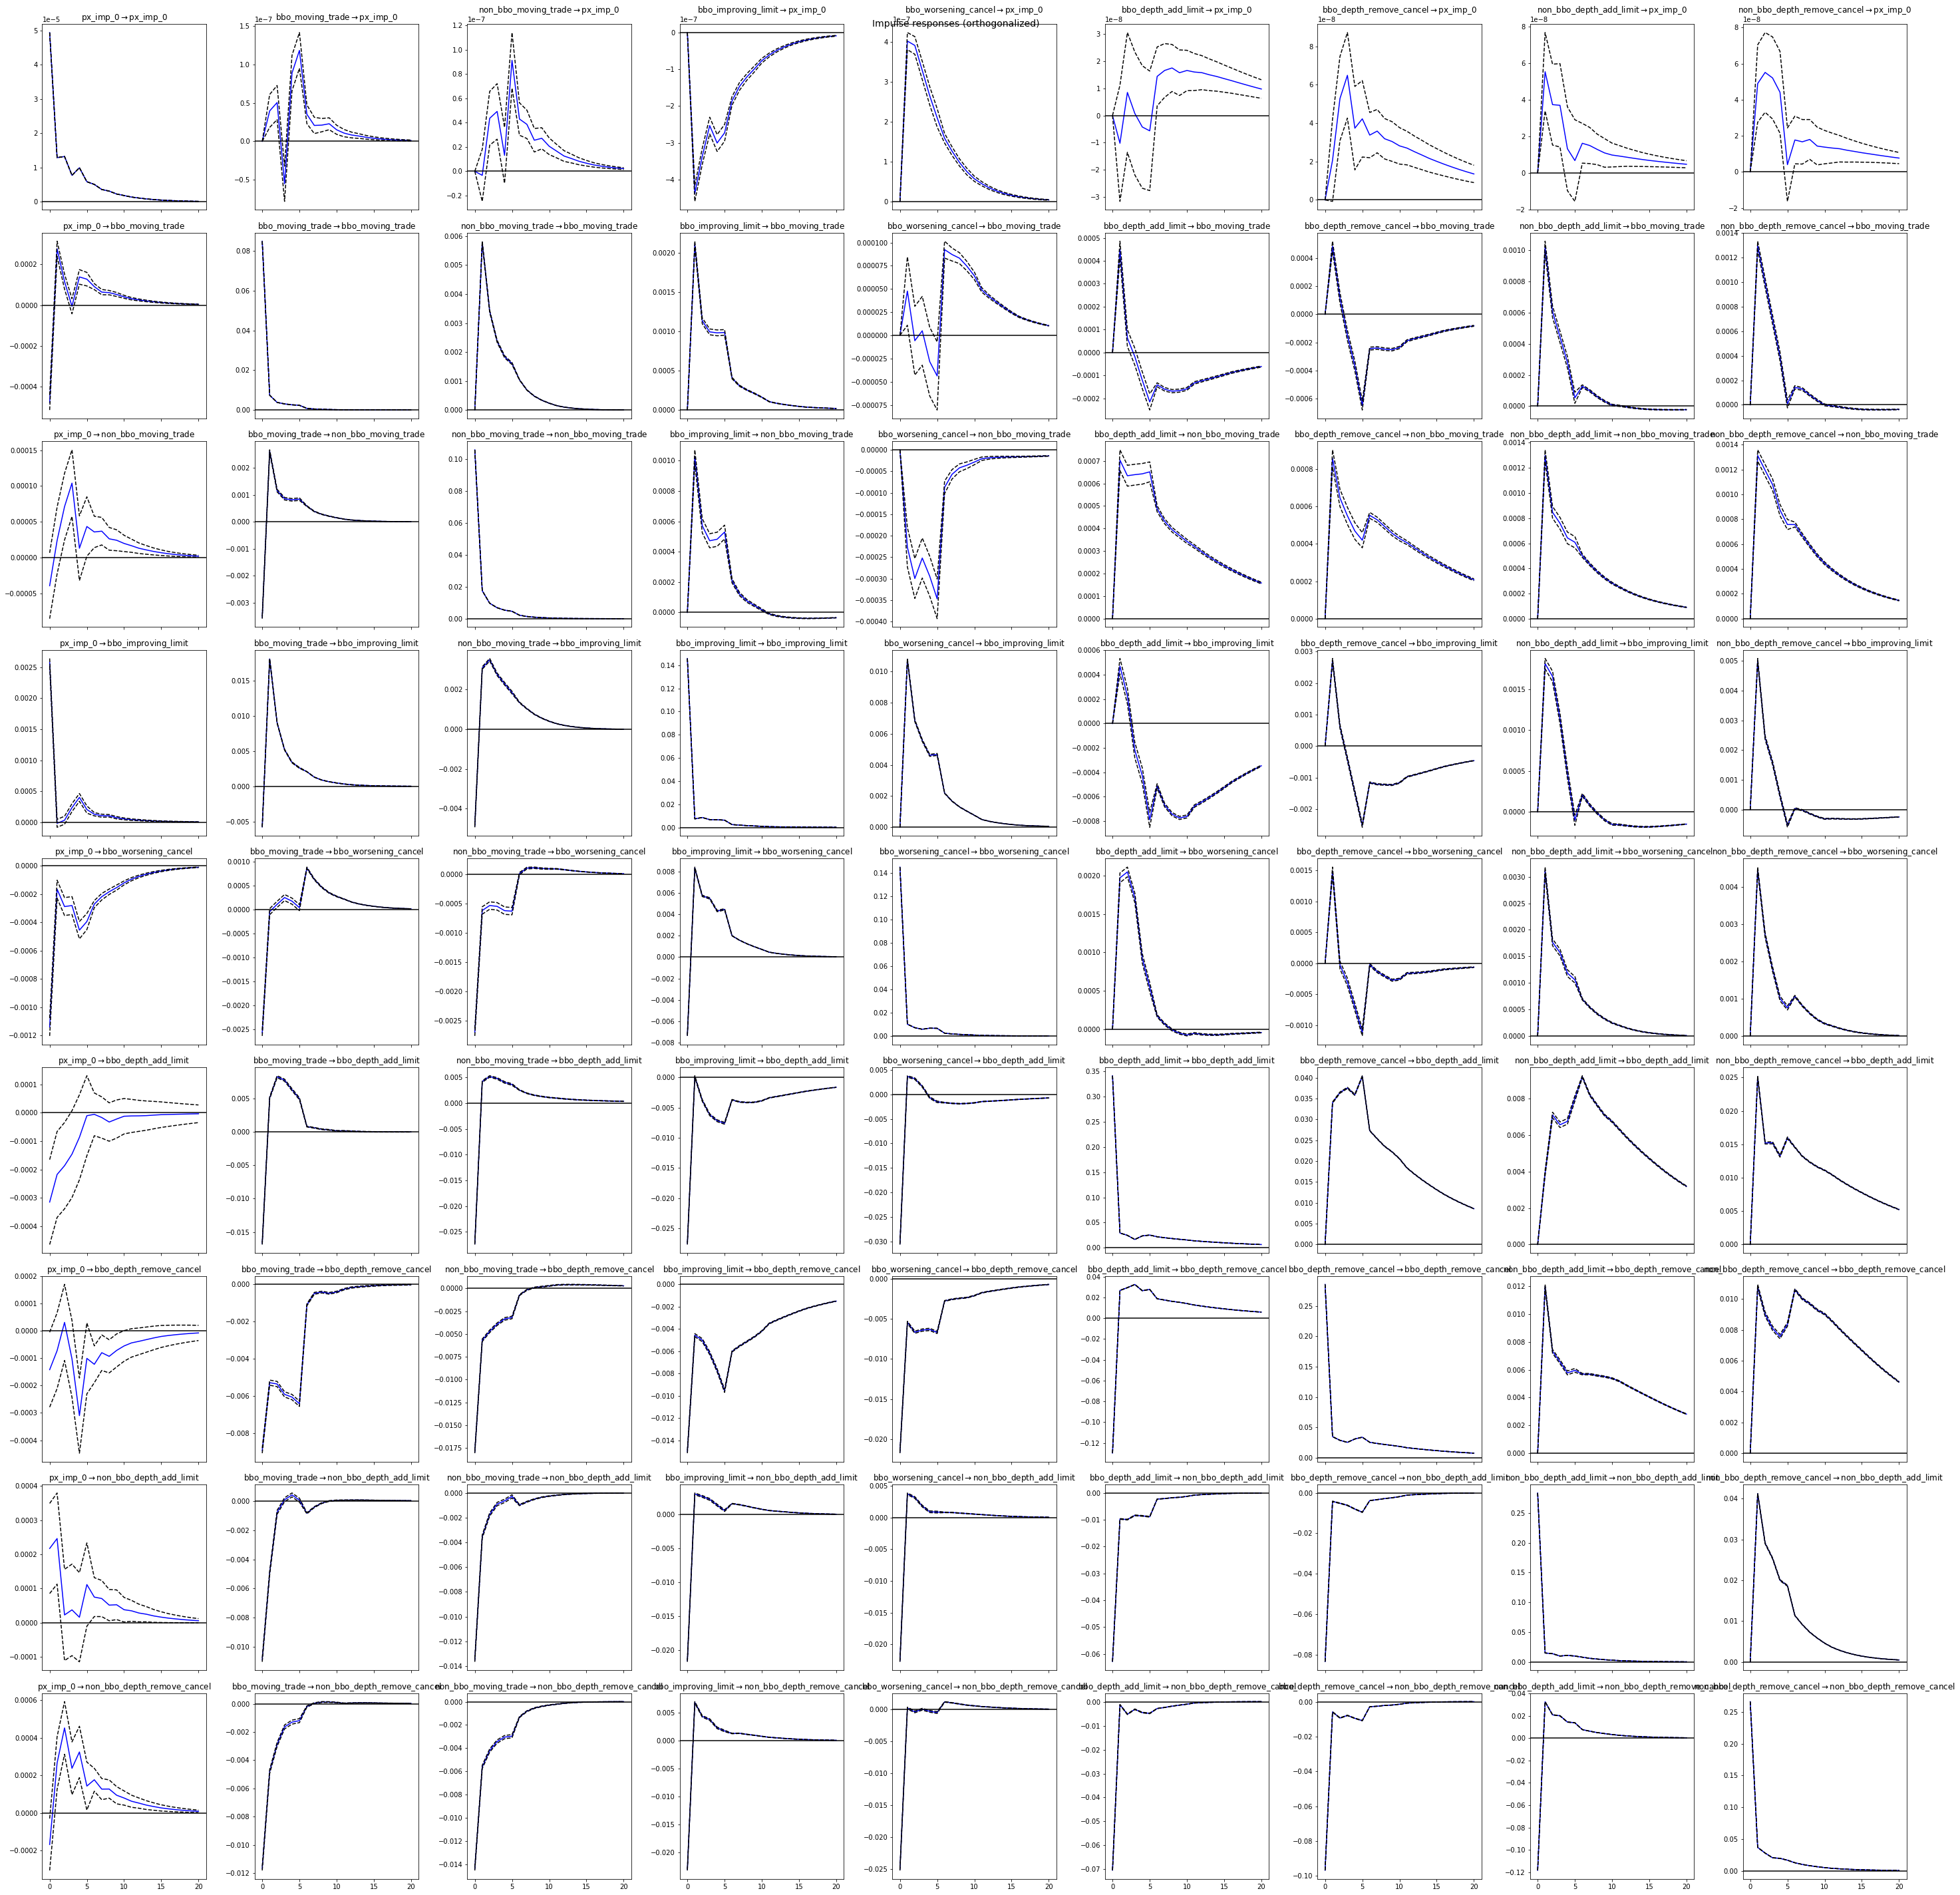

In [26]:


df = pd.read_parquet('/data/workspace_files/train_oct/third_week_df.parquet')
df.index = pd.to_datetime(df['ts_event'])
df = df[['px_imp_0', 'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
         'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
         'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel']]

# Create and fit the VAR model (using 5 lags for this example)
model = VAR(df)
results = model.fit(5)

# Compute the impulse response function for 20 periods ahead
irf = results.irf(20)

# Plot the IRF for all variables
irf.plot(orth=True, figsize=(40, 40))  # Set orth=True if you want orthogonalized IRFs
plt.tight_layout()
plt.show()

# Optionally, you can extract the IRF values as a NumPy array:
irf_values = irf.irfs  # shape: (steps+1, number of variables, number of variables)
print("Impulse response values:\n", irf_values)

In [6]:
def IRF(df_raw, event_side, prefix):
    if event_side == 'A':
        title_side = 'Asks'
    else:
        title_side = 'Bids'

    df = df_raw.copy()

    df.index = pd.to_datetime(df['ts_event'])
    df = df[['side', 'px_imp_0', 'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
            'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
            'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel']]
 
    df = df[df['side'] == event_side]
    df = df.drop(columns='side')

    # Create and fit the VAR model (using 5 lags for this example)
    model = VAR(df)
    results = model.fit(5)

    # Compute the impulse response function for 20 periods ahead
    irf = results.irf(20)
    irf_array = irf.irfs  # shape: (steps+1, n_vars, n_vars)
    steps = np.arange(irf_array.shape[0])

    # Identify the target variable and its index
    target_variable = 'px_imp_0'
    target_index = results.names.index(target_variable)

    # Create a list of shock indices (and names) excluding the target variable
    shock_list = [(i, name) for i, name in enumerate(results.names) if i != target_index]

    # Create a 2x4 subplot grid (for 8 shocks)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    # Loop over each shock variable and plot the response of px_imp_0
    for ax, (shock_index, shock_name) in zip(axs, shock_list):
        response = irf_array[:, target_index, shock_index]
        ax.plot(steps, response, marker='o')
        ax.axhline(0, color='black', linestyle='--')
        ax.set_title(f'Shock: {shock_name}')
        ax.set_xlabel("Horizon")
        ax.set_ylabel(f"Response of {target_variable}")

    fig.suptitle(f'Impulse Response Functions for {title_side}')
    plt.tight_layout()
    plt.savefig(f"{prefix}_IRF_{event_side}.png", dpi=300, bbox_inches="tight")
    plt.show()
    

    # Create a 2x4 subplot grid (for 8 shocks)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    result = {}

    # Loop over each shock variable and plot the response of px_imp_0
    for ax, (shock_index, shock_name) in zip(axs, shock_list):
        response = irf_array[:, target_index, shock_index].cumsum()
        result[shock_name] = response[-1]
        ax.plot(steps, response, marker='o')
        ax.axhline(0, color='black', linestyle='--')
        ax.set_title(f'Shock: {shock_name}')
        ax.set_xlabel("Horizon")
        ax.set_ylabel(f"Cumulative Response of {target_variable}")

    fig.suptitle(f'Cumulative Impulse Response Functions for {title_side}')
    plt.tight_layout()
    plt.savefig(f"{prefix}_Cumu_IRF_{event_side}.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    return result

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

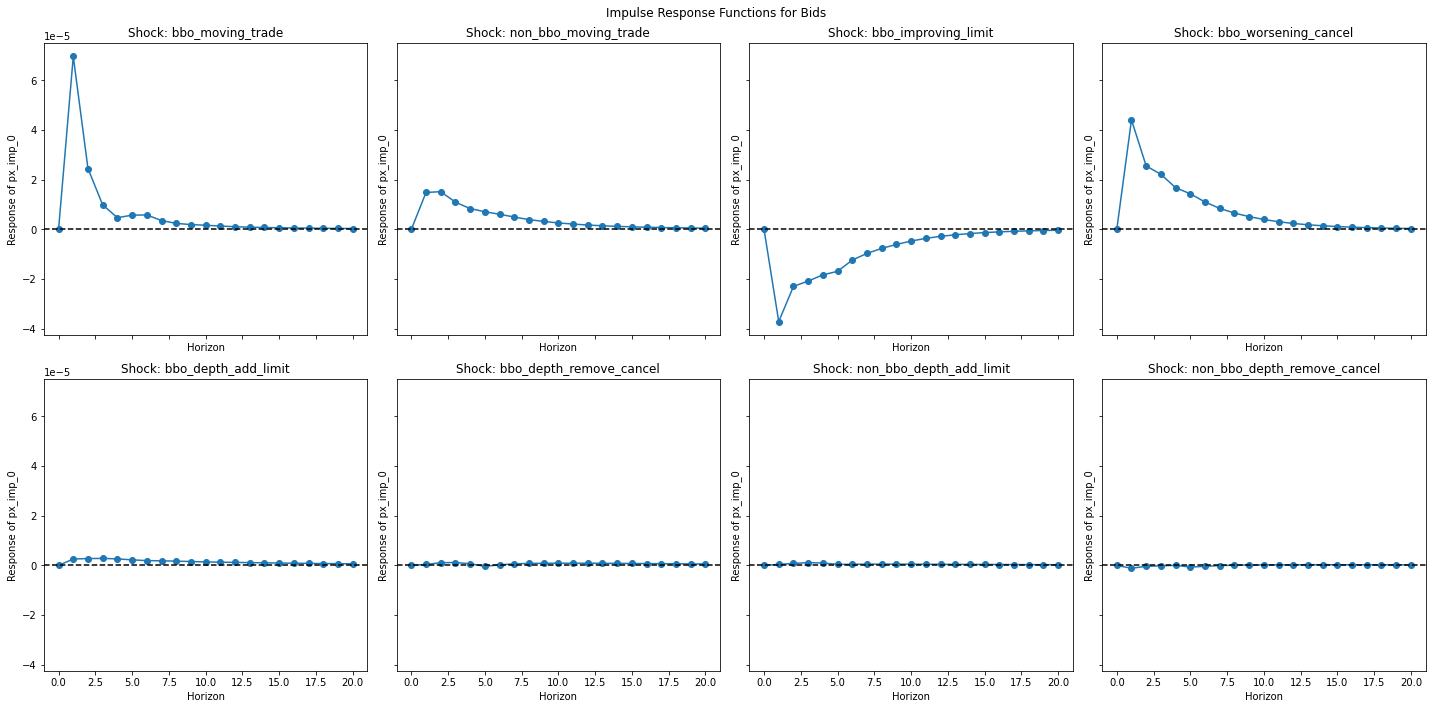

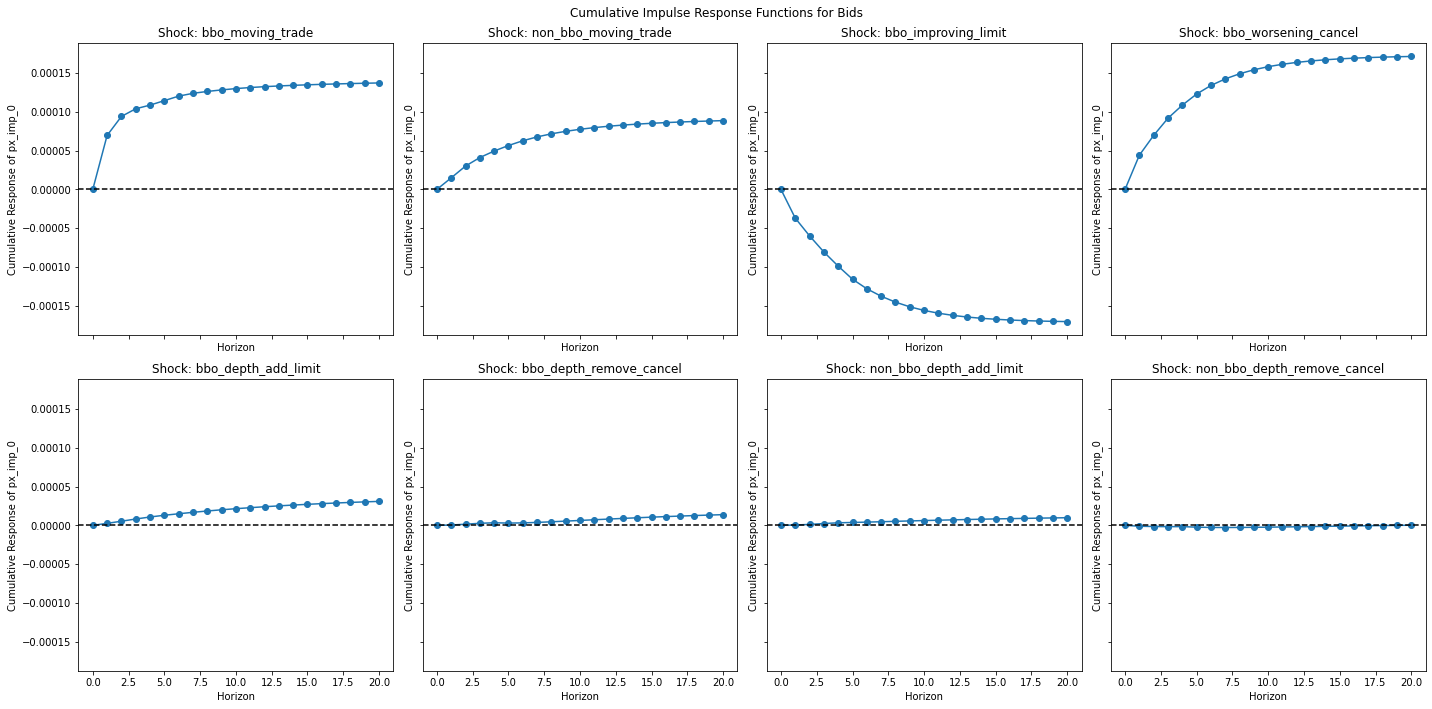

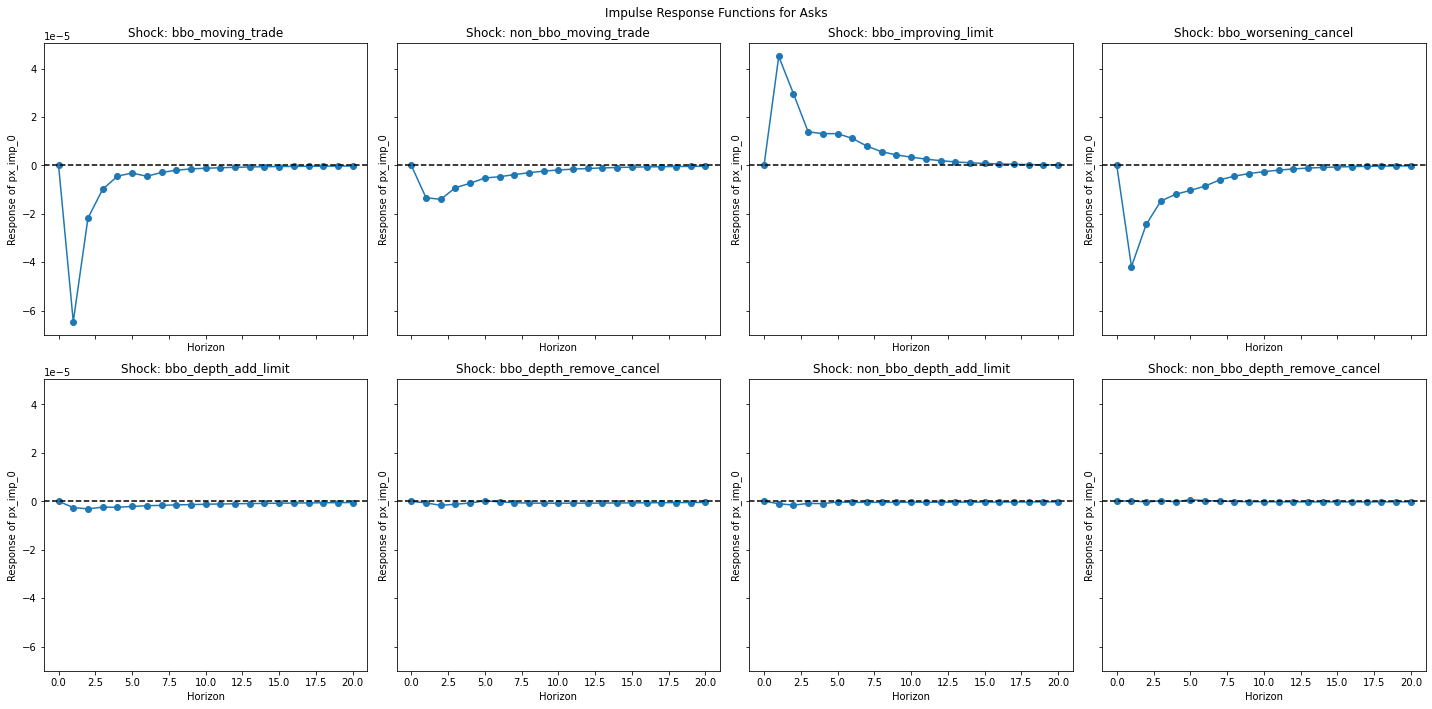

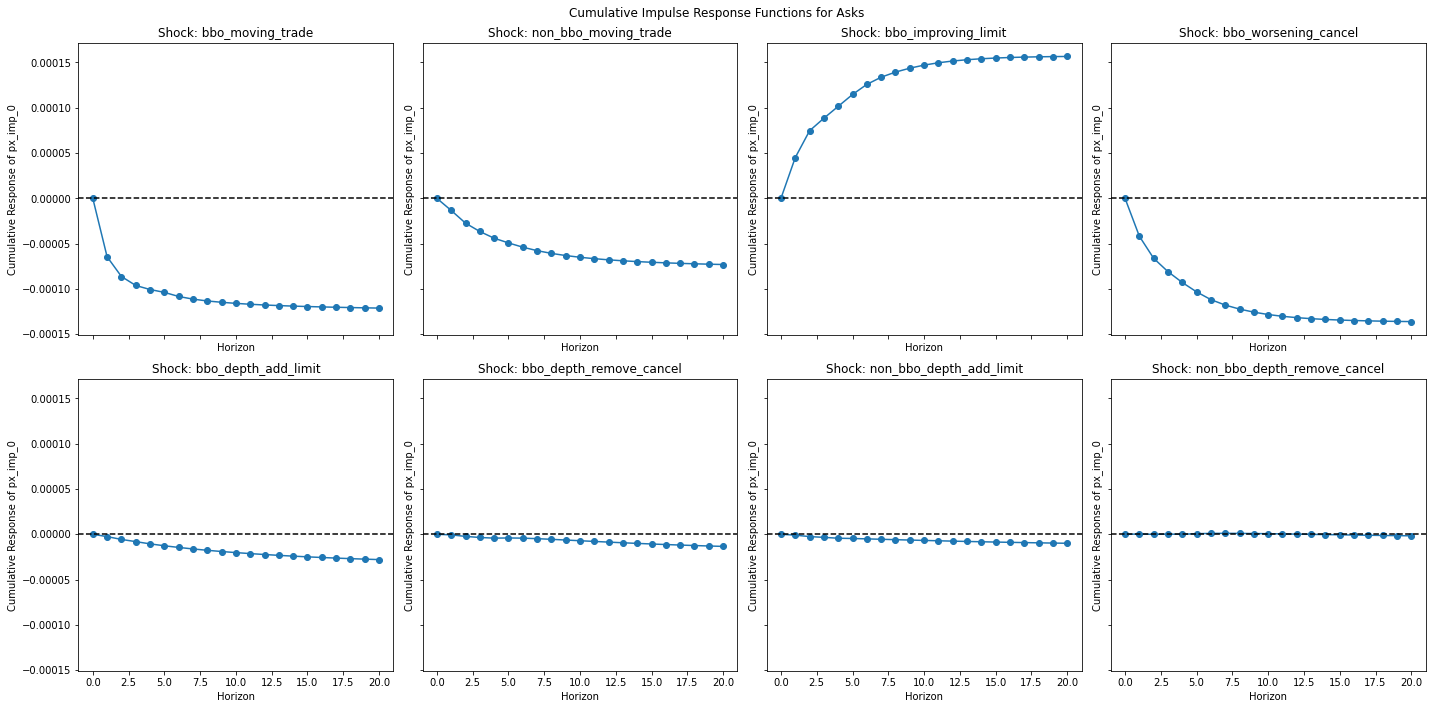

In [7]:
tracker = {}
tracker['B'] = {}
tracker['A'] = {}

df = pd.read_parquet('/data/workspace_files/train_oct/first_week_df.parquet')
tracker['B']['first_week_oct'] = IRF(df, 'B', 'first_week_oct')
tracker['A']['first_week_oct'] = IRF(df, 'A', 'first_week_oct')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

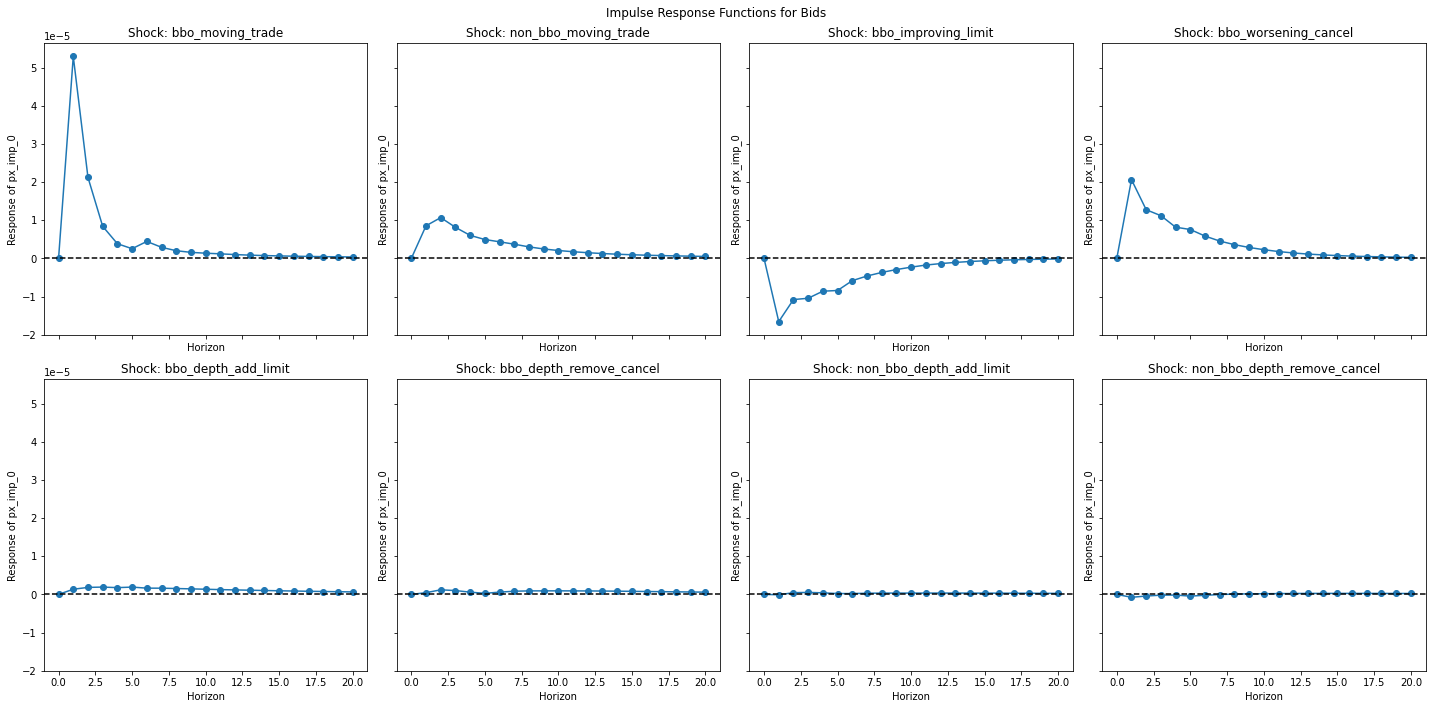

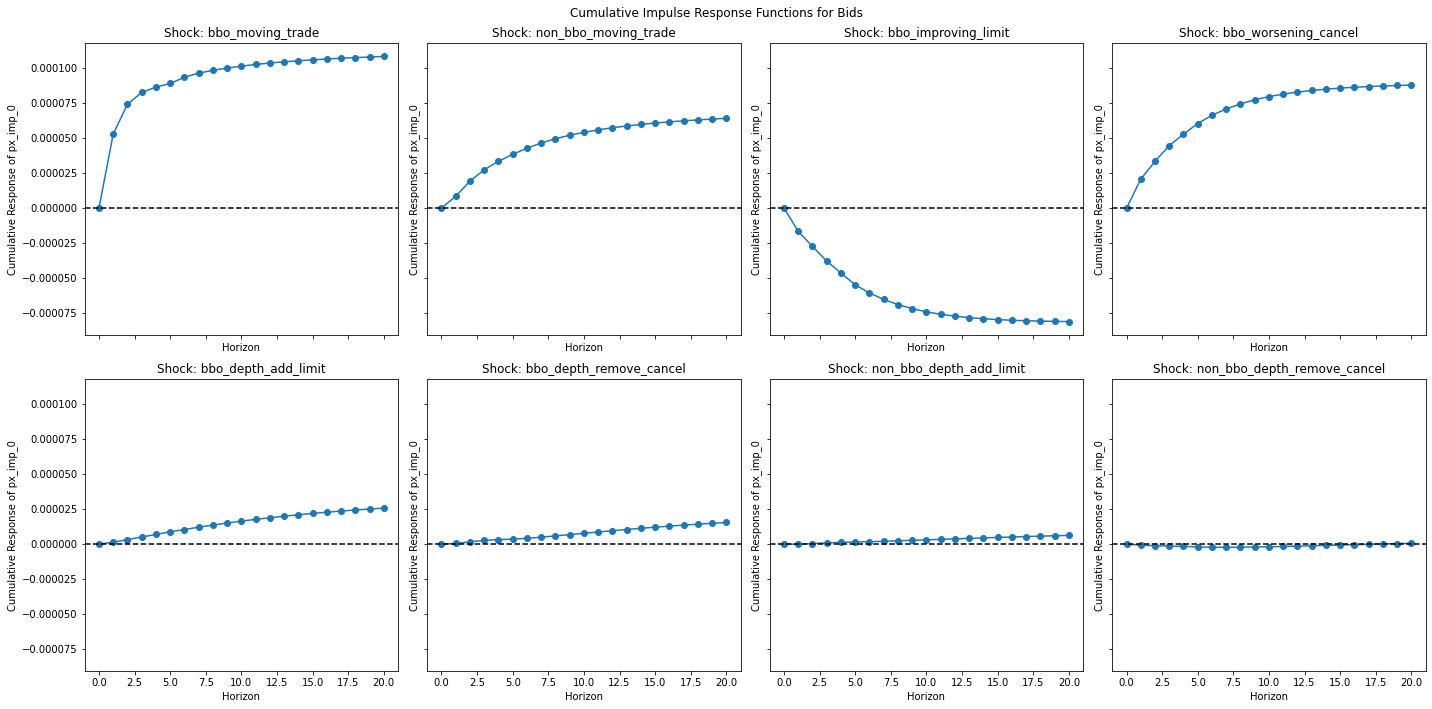

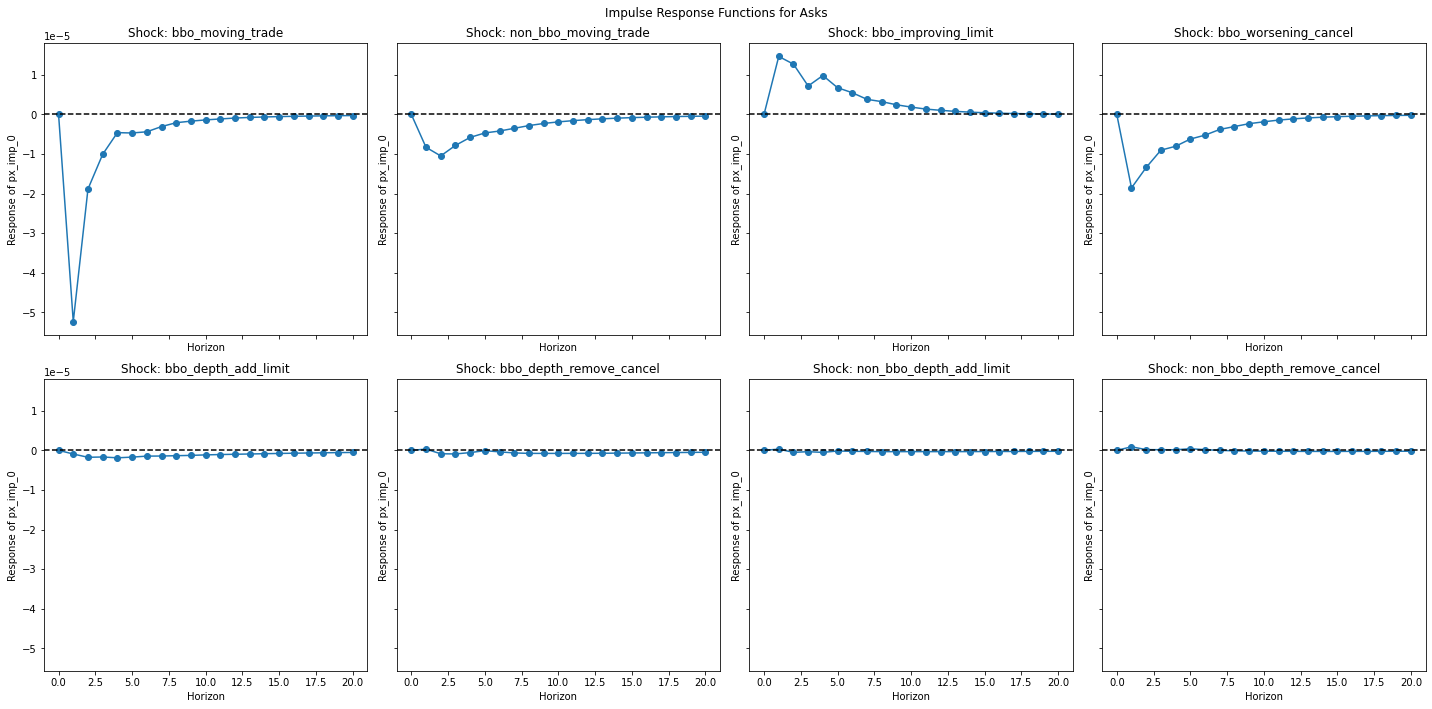

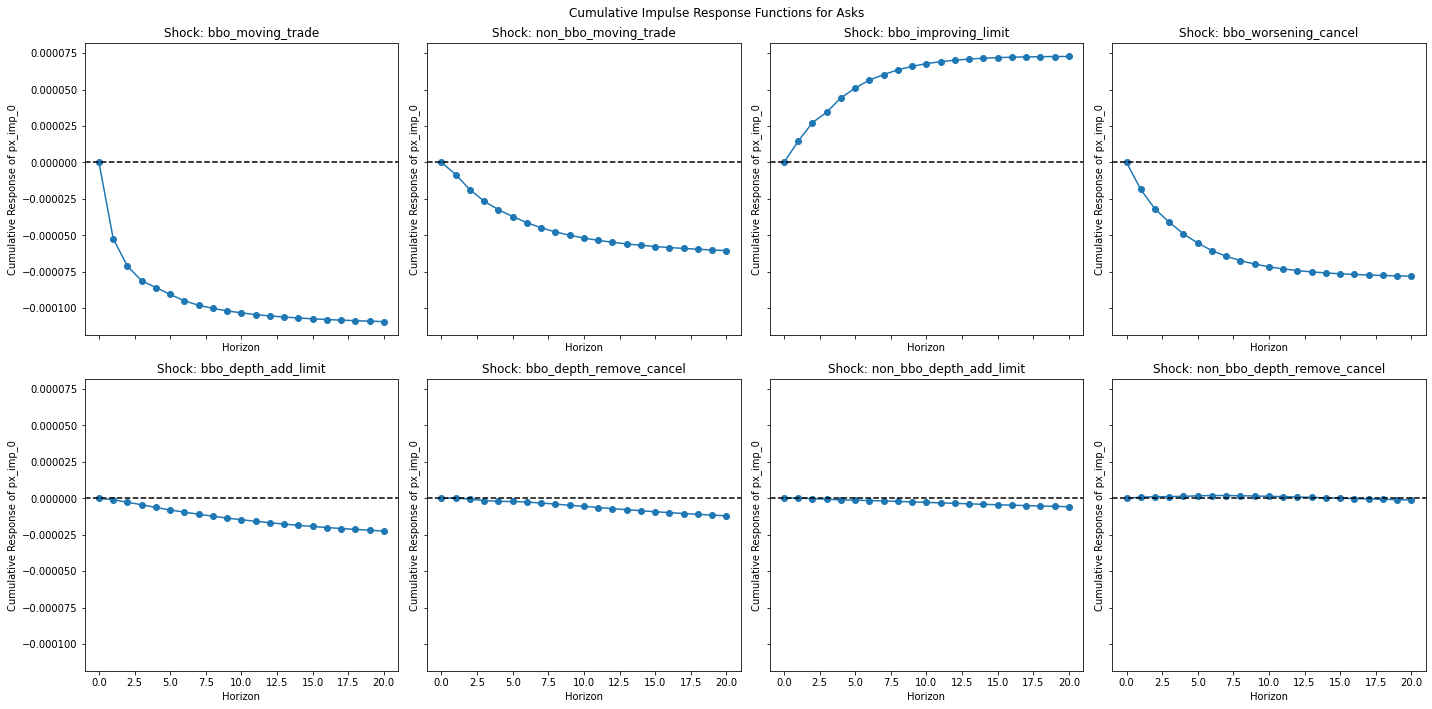

In [8]:
df = pd.read_parquet('/data/workspace_files/val_oct/second_week_df.parquet')
tracker['B']['second_week_oct'] = IRF(df, 'B', 'second_week_oct')
tracker['A']['second_week_oct'] = IRF(df, 'A', 'second_week_oct')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

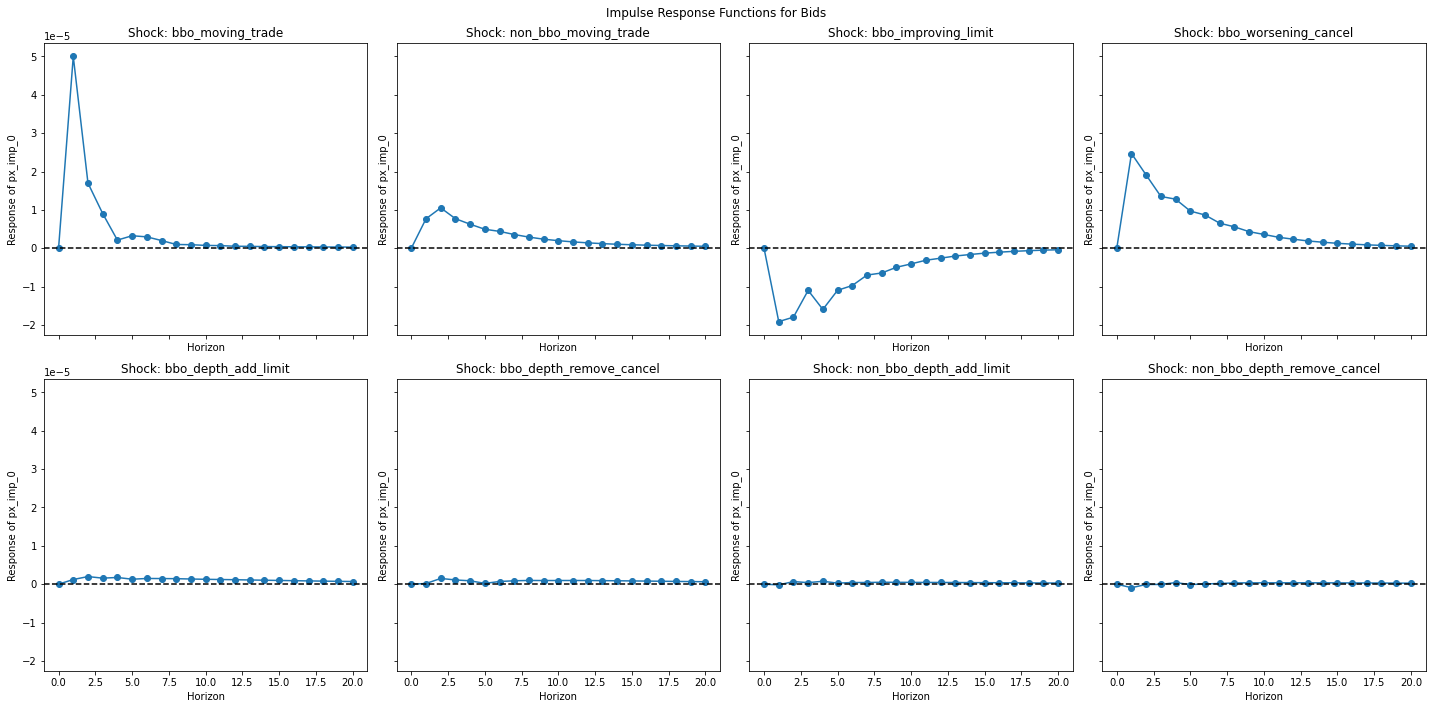

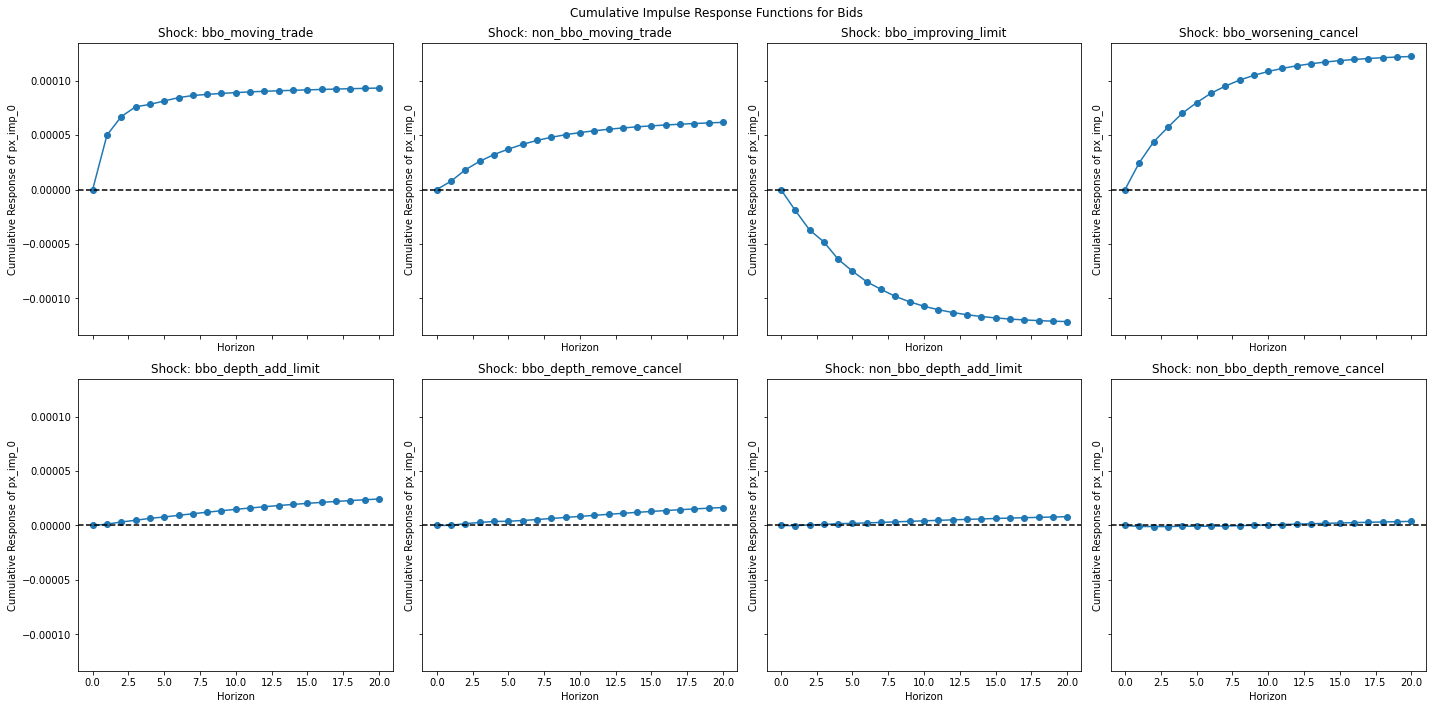

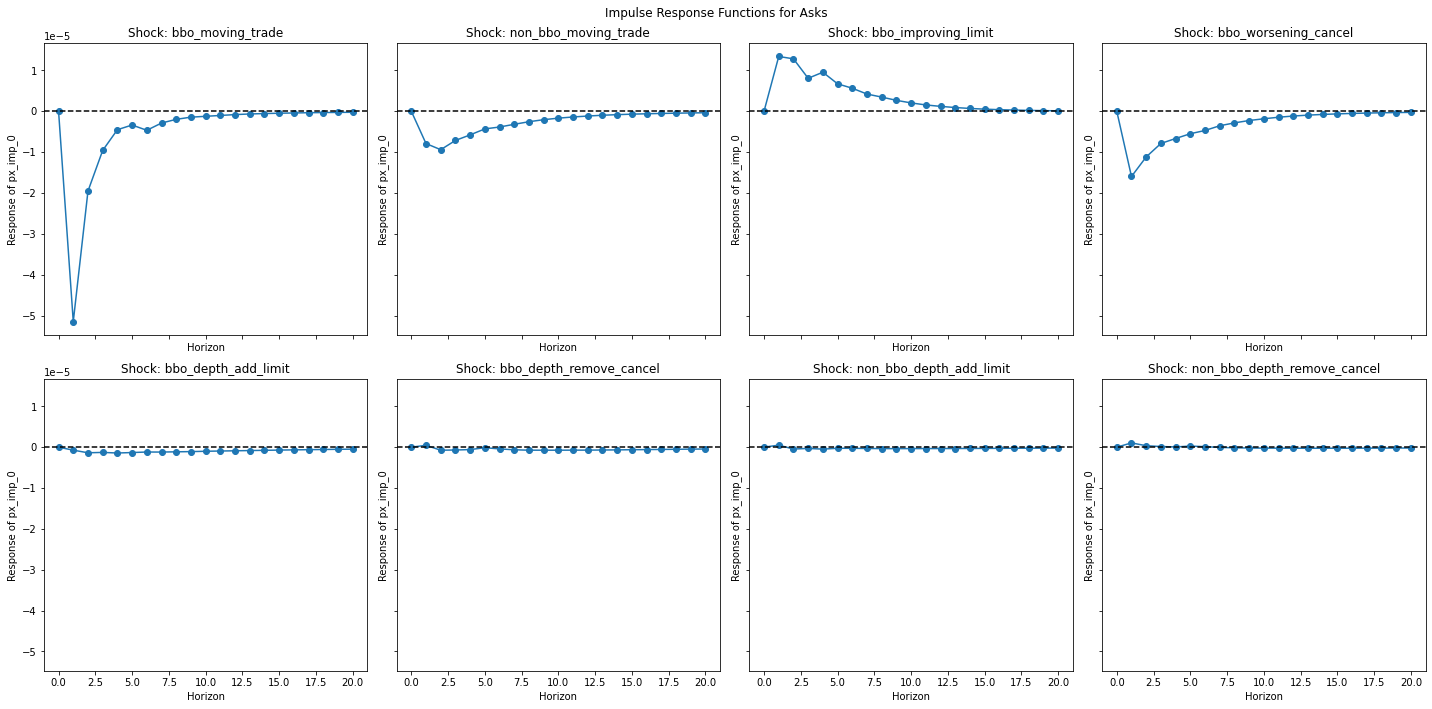

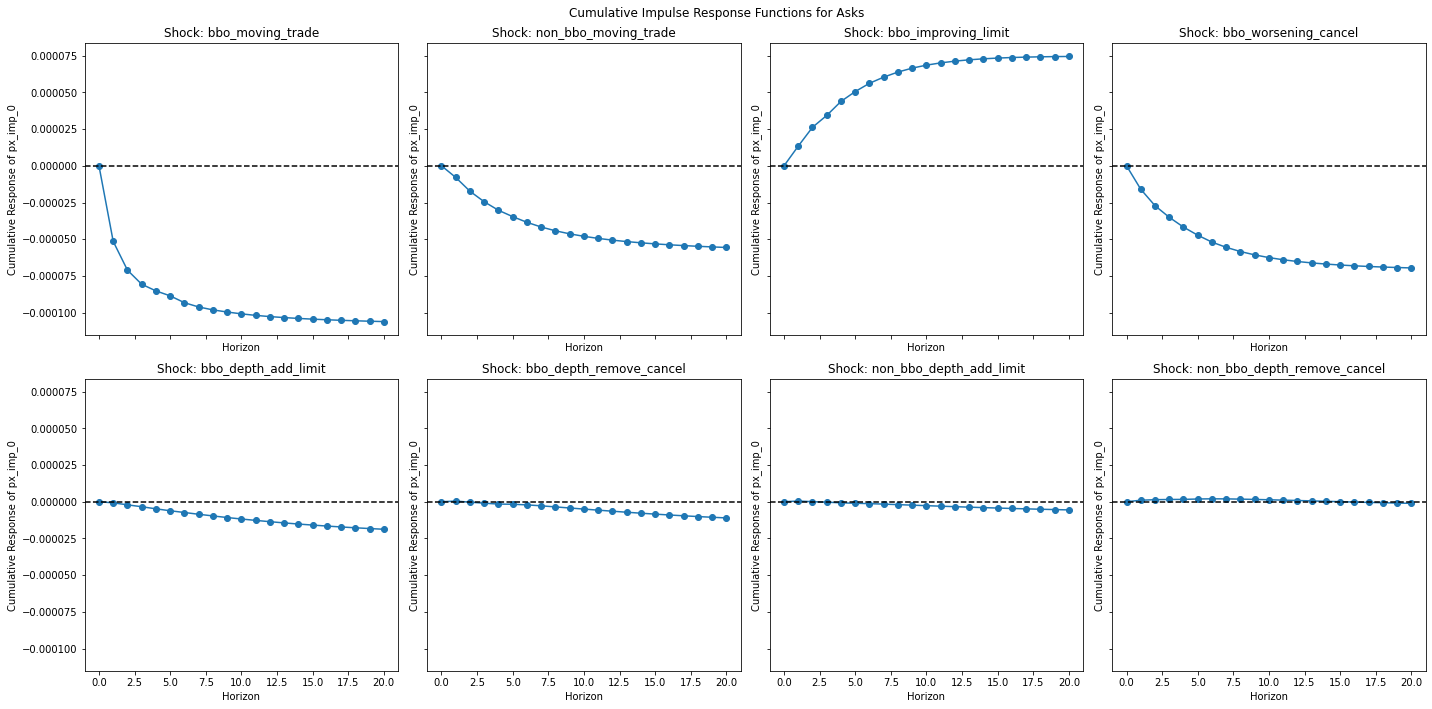

In [9]:
df = pd.read_parquet('/data/workspace_files/train_oct/third_week_df.parquet')
tracker['B']['third_week_oct'] = IRF(df, 'B', 'third_week_oct')
tracker['A']['third_week_oct'] = IRF(df, 'A', 'third_week_oct')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

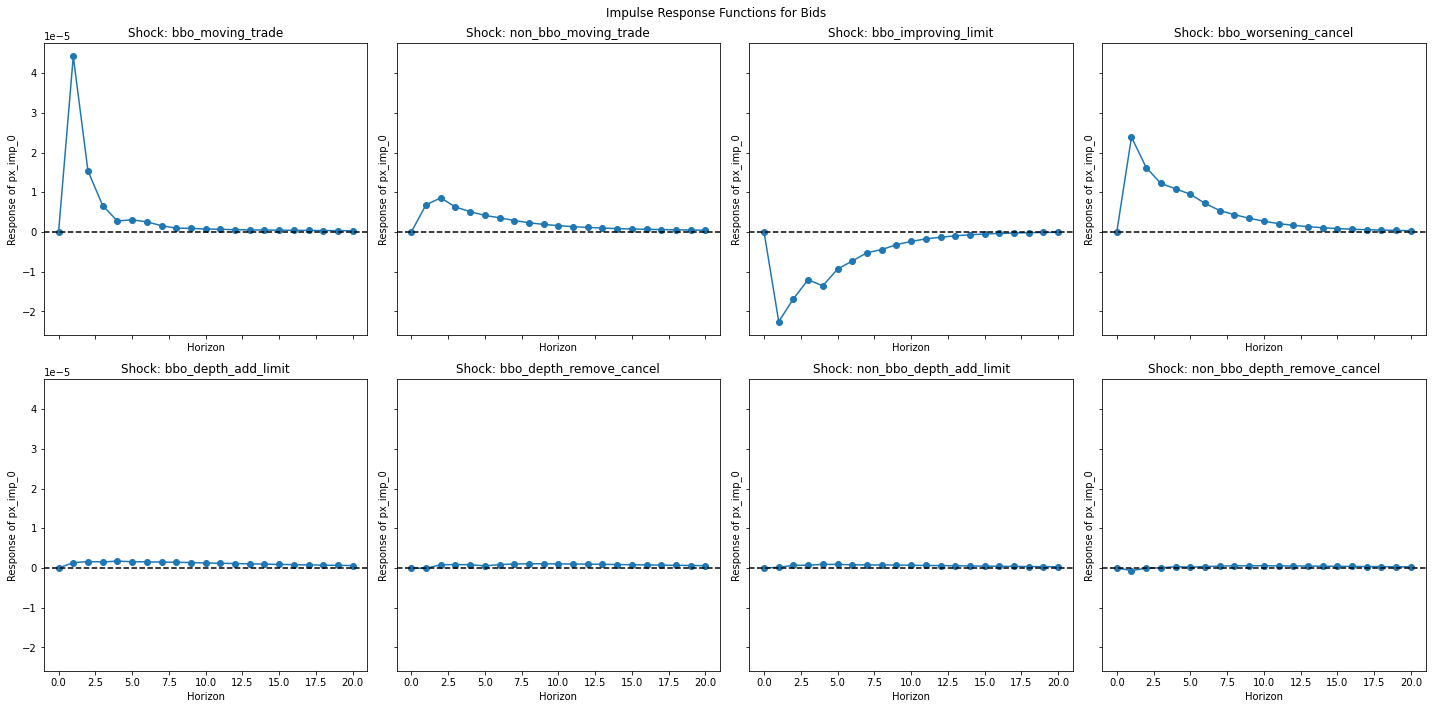

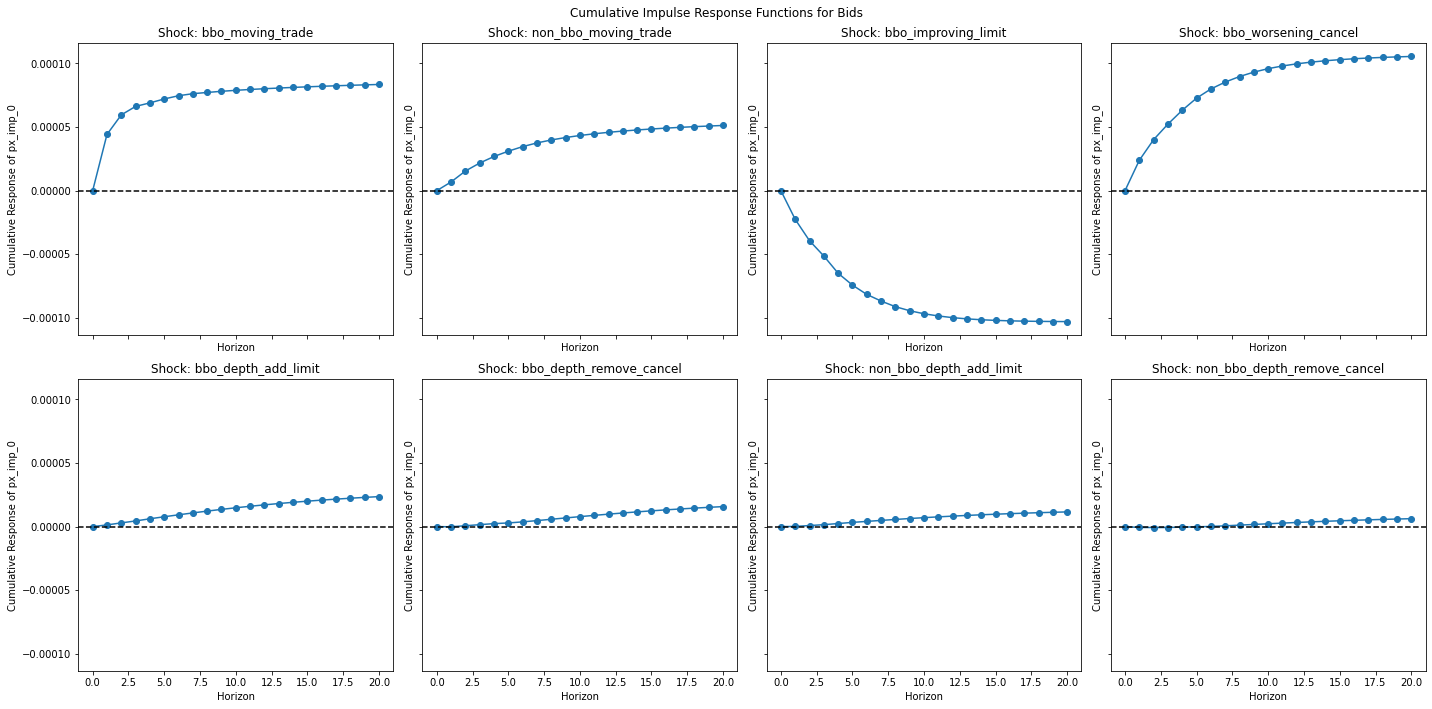

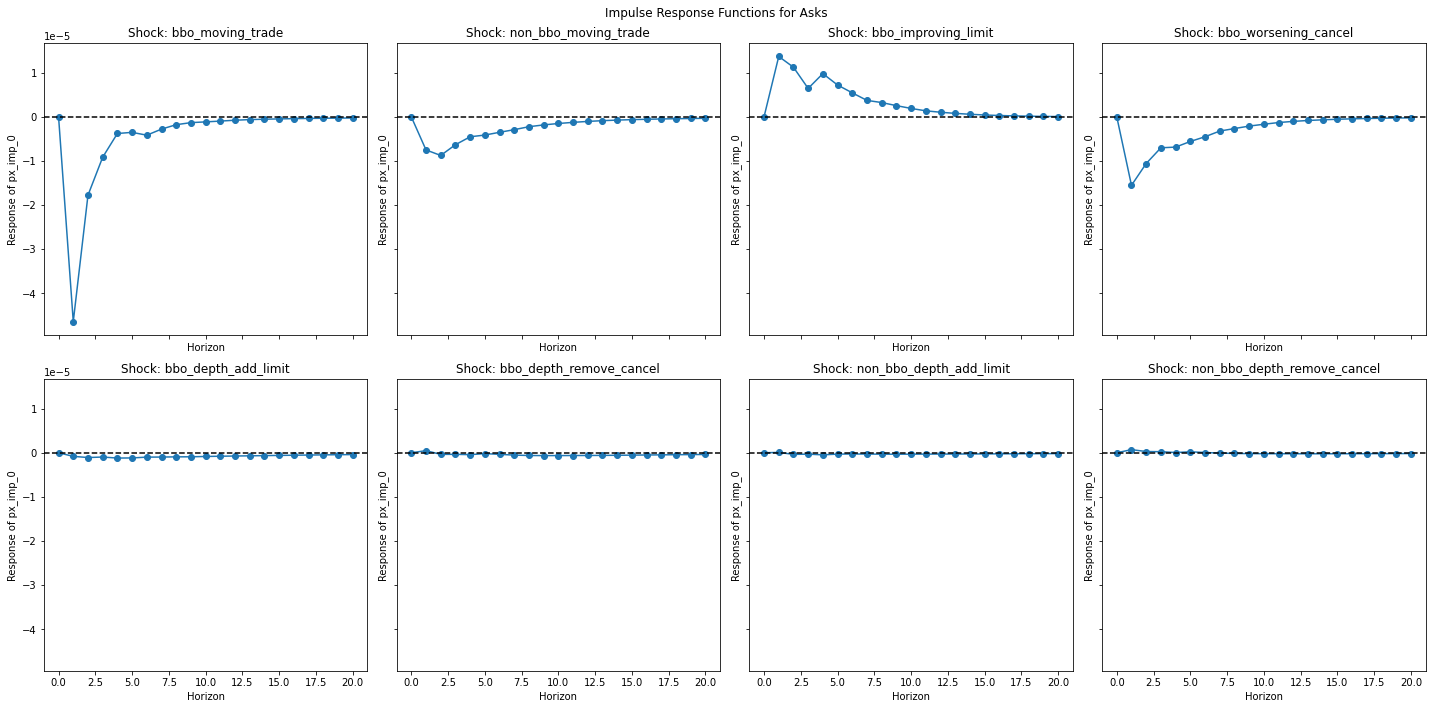

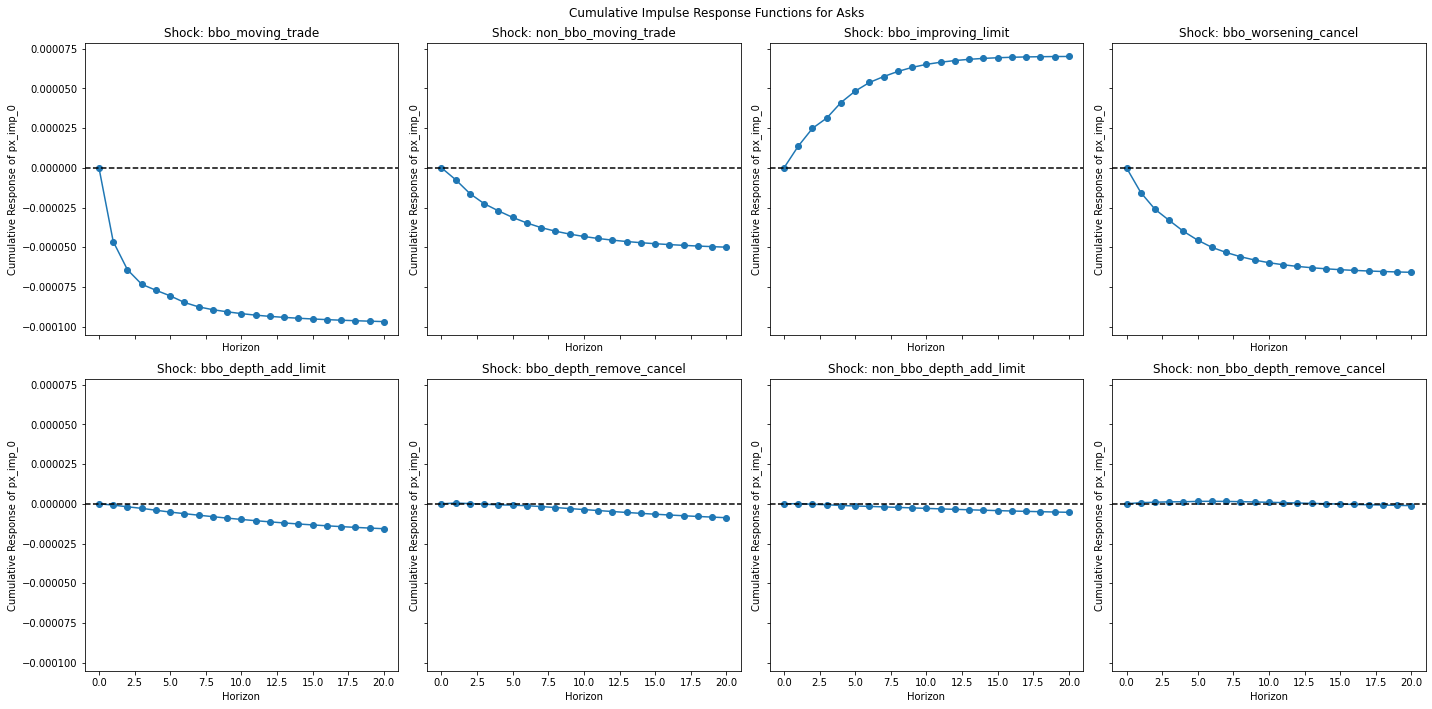

In [10]:
df = pd.read_parquet('/data/workspace_files/val_oct/fourth_week_df.parquet')
tracker['B']['fourth_week_oct'] = IRF(df, 'B', 'fourth_week_oct')
tracker['A']['fourth_week_oct'] = IRF(df, 'A', 'fourth_week_oct')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

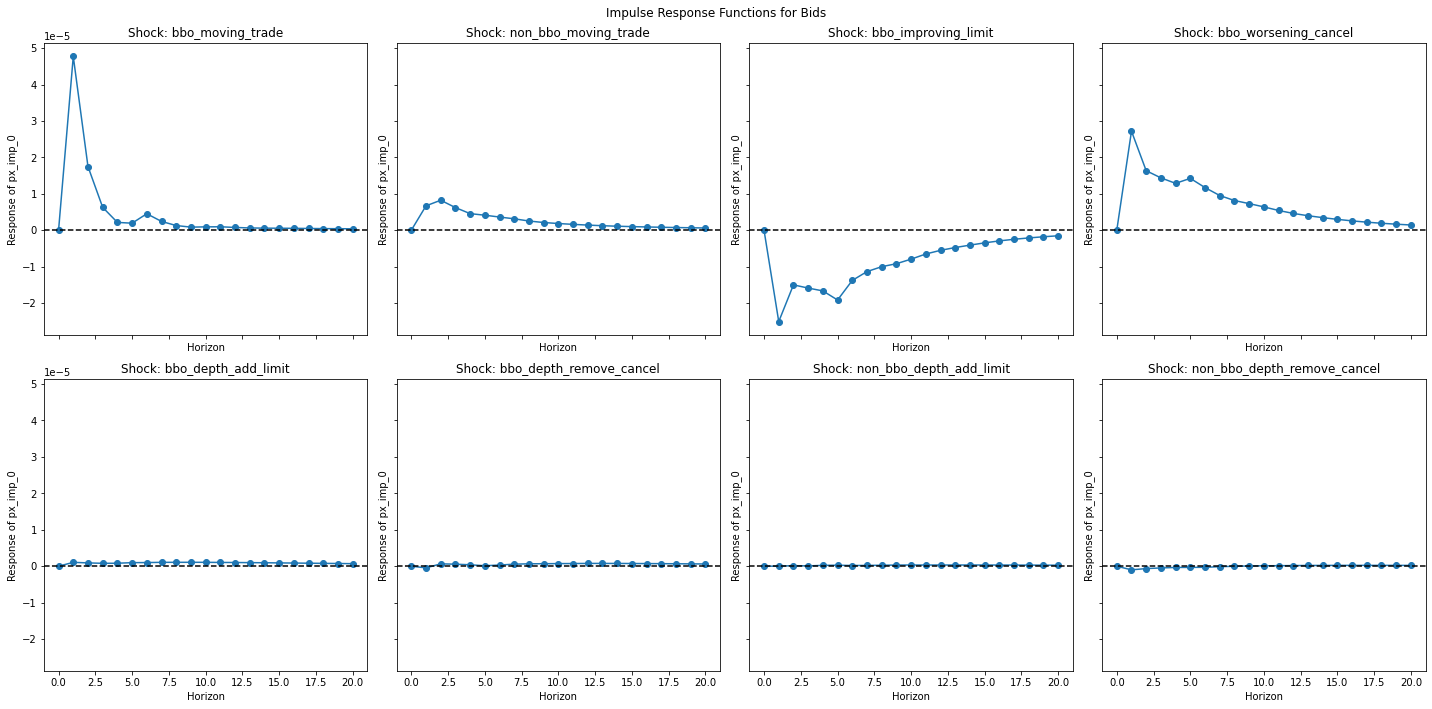

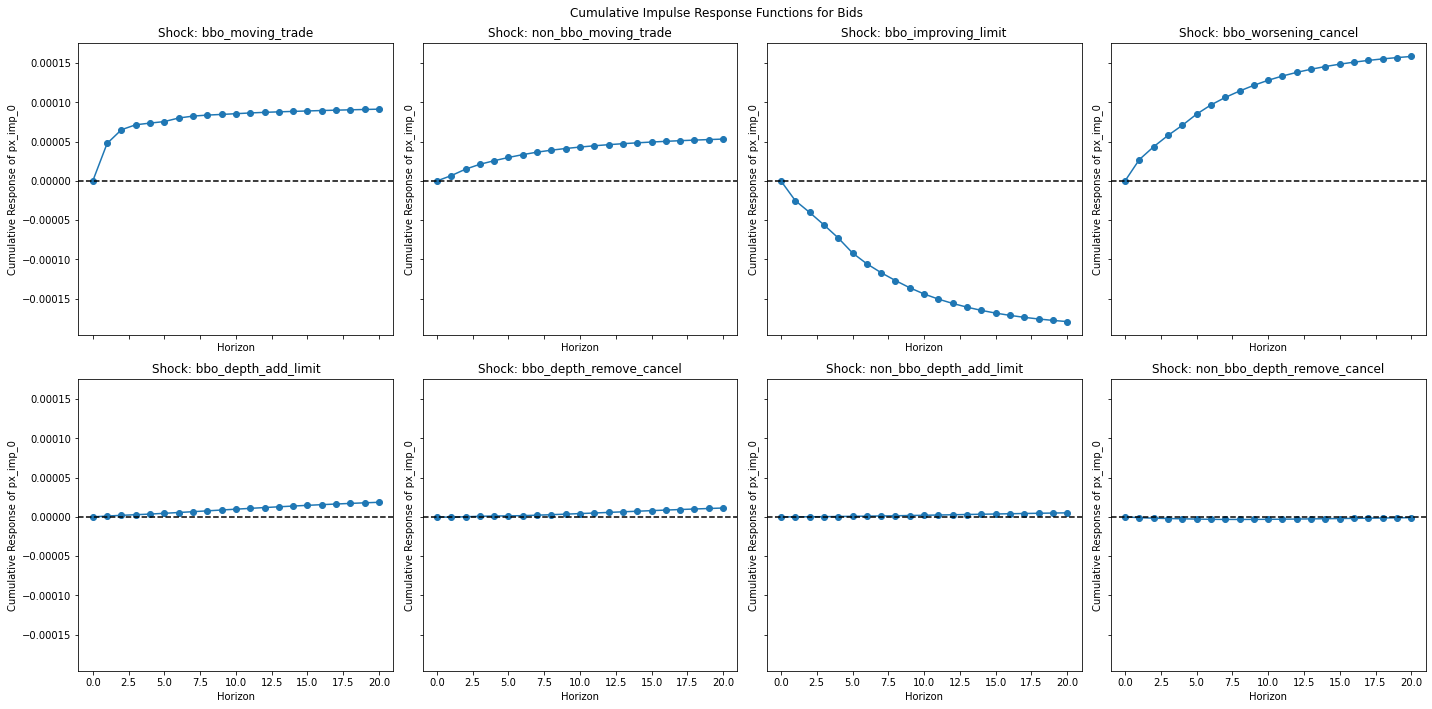

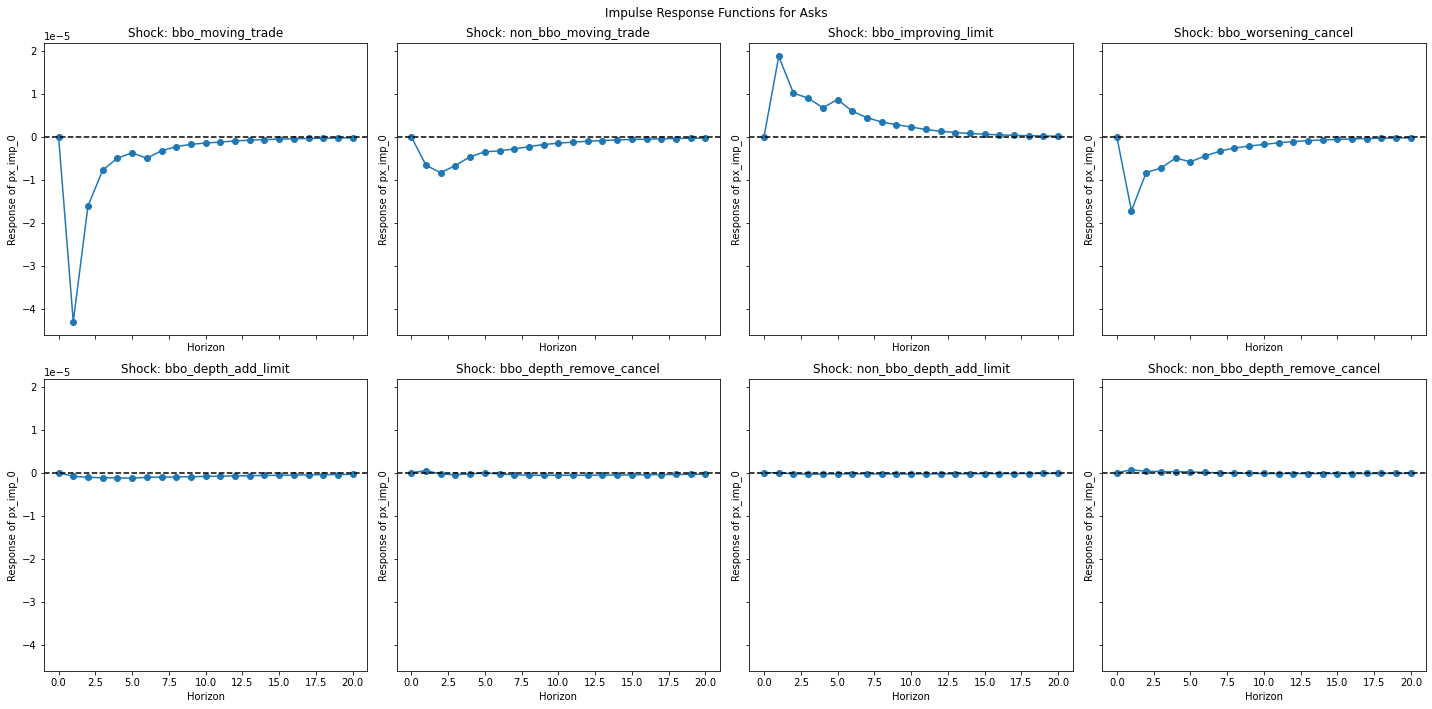

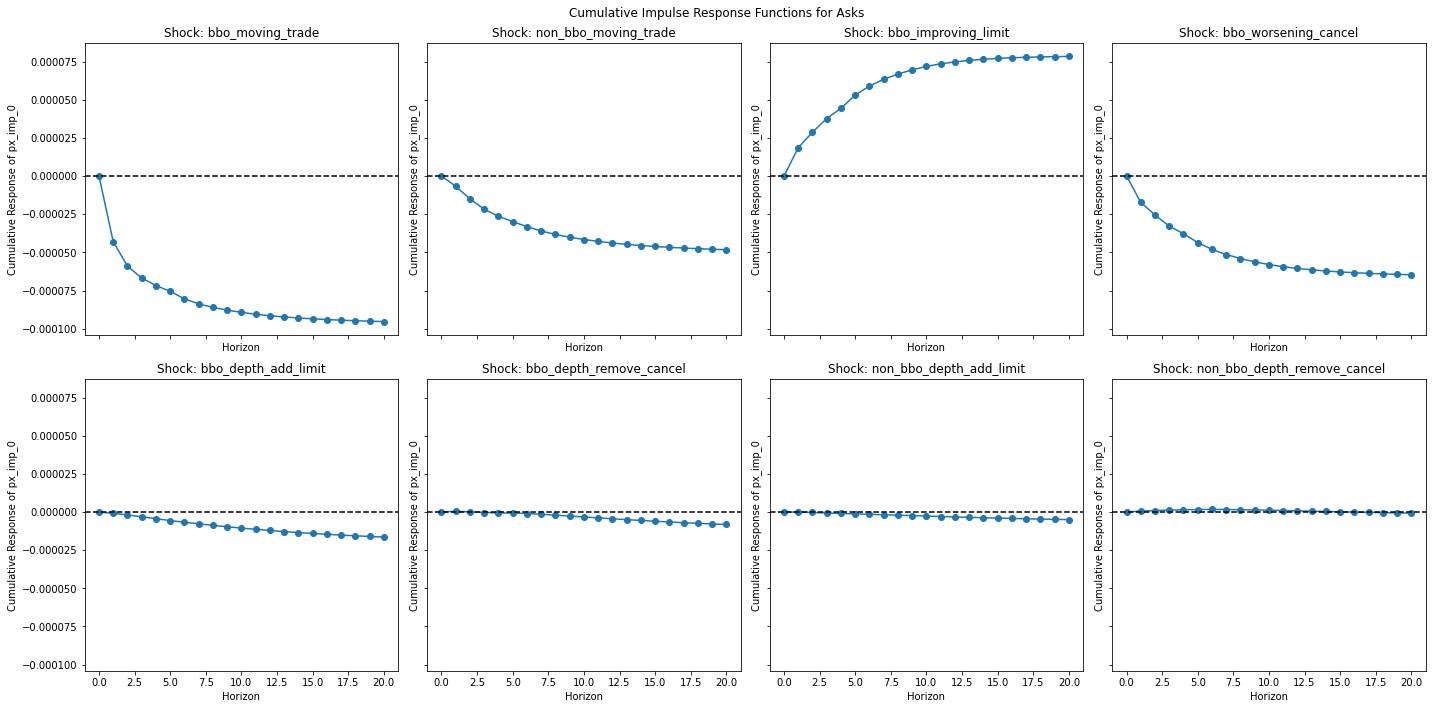

In [11]:
df = pd.read_parquet('/data/workspace_files/train_oct/fifth_week_df.parquet')
tracker['B']['fifth_week_oct'] = IRF(df, 'B', 'fifth_week_oct')
tracker['A']['fifth_week_oct'] = IRF(df, 'A', 'fifth_week_oct')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

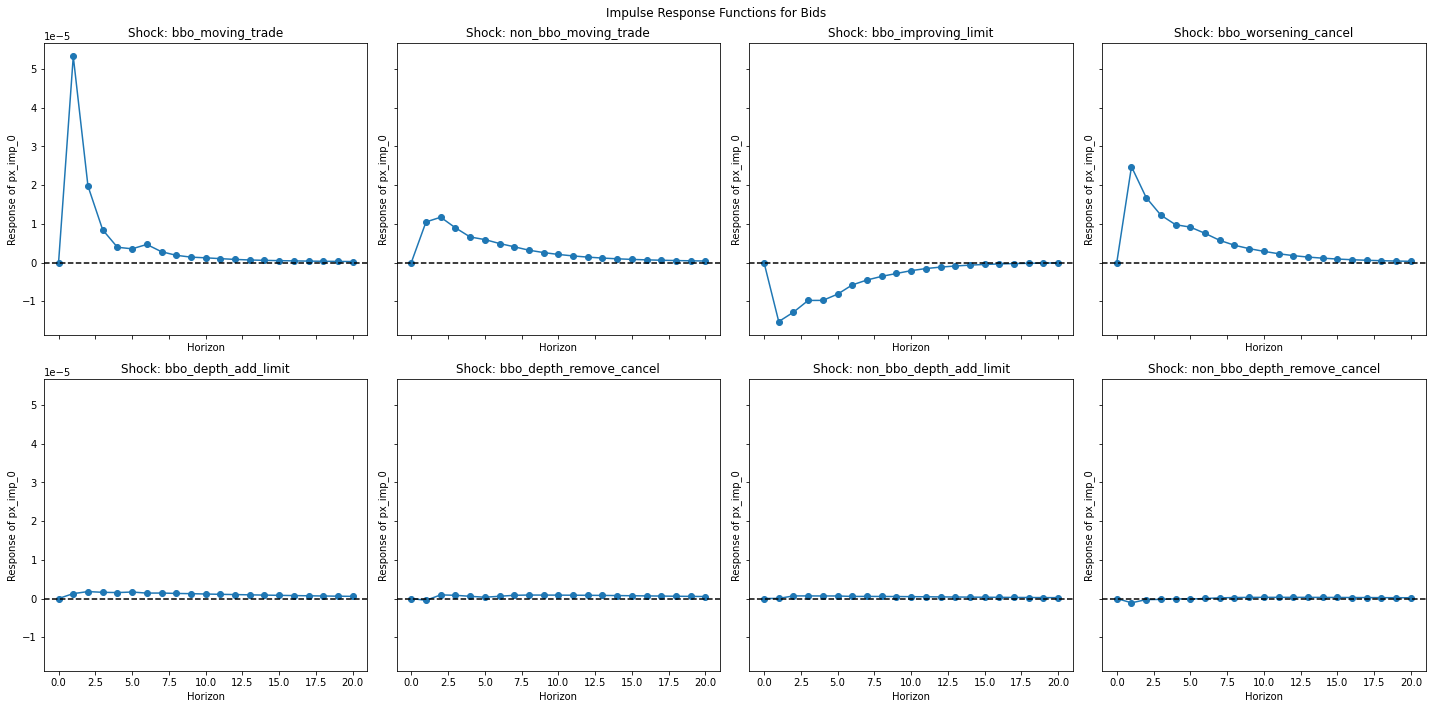

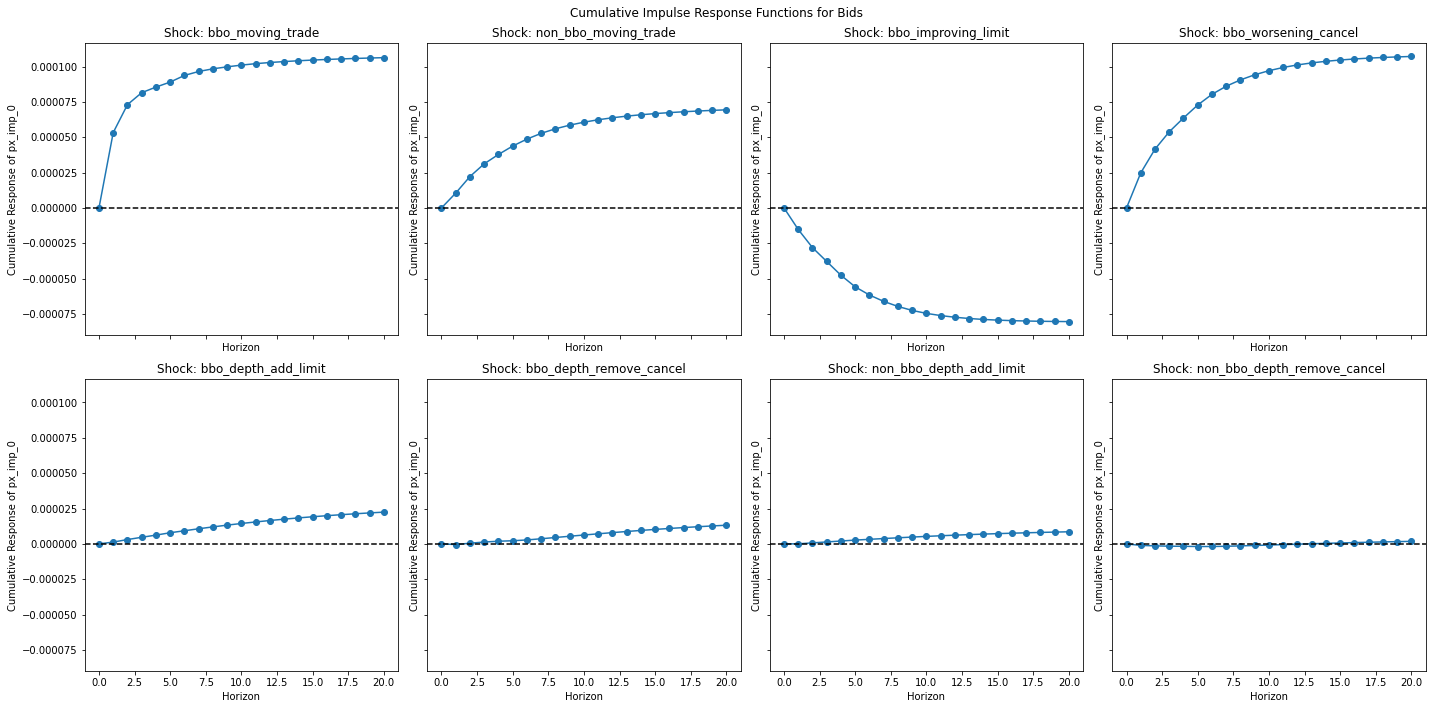

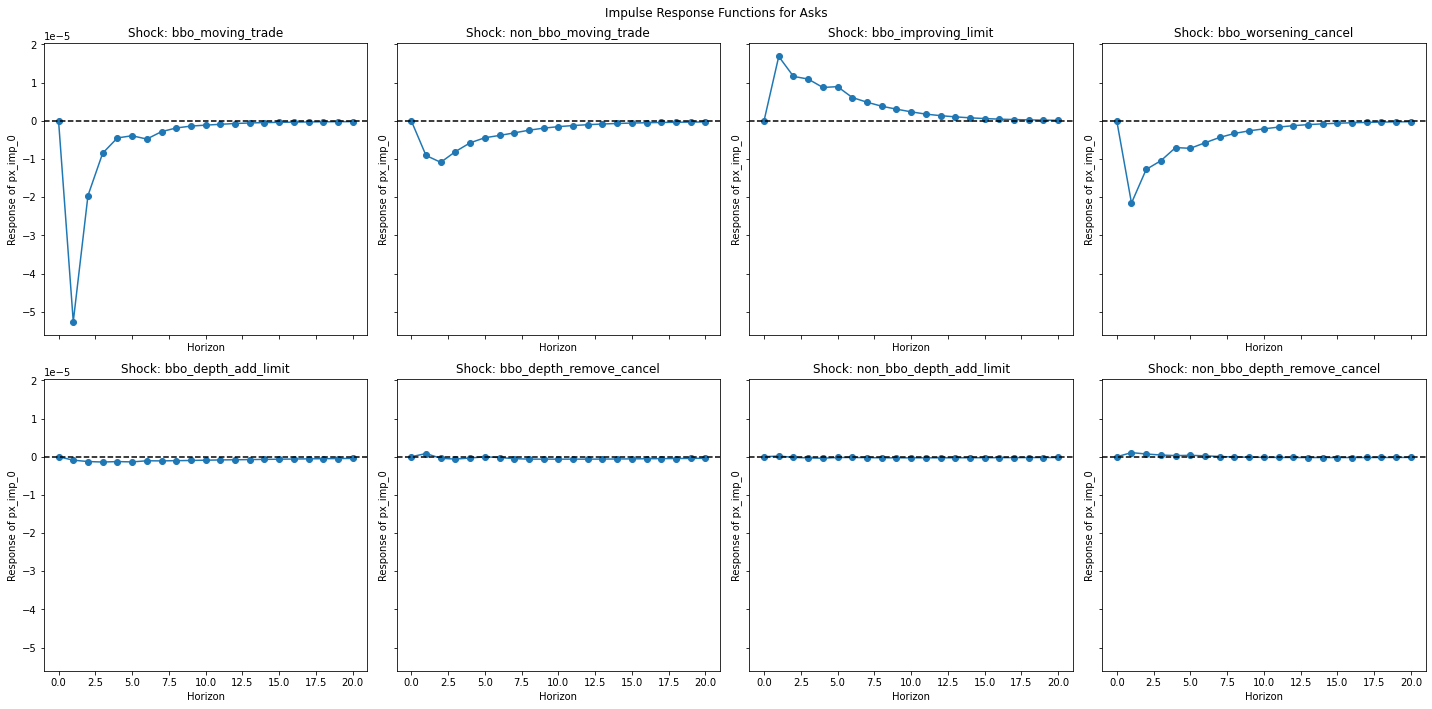

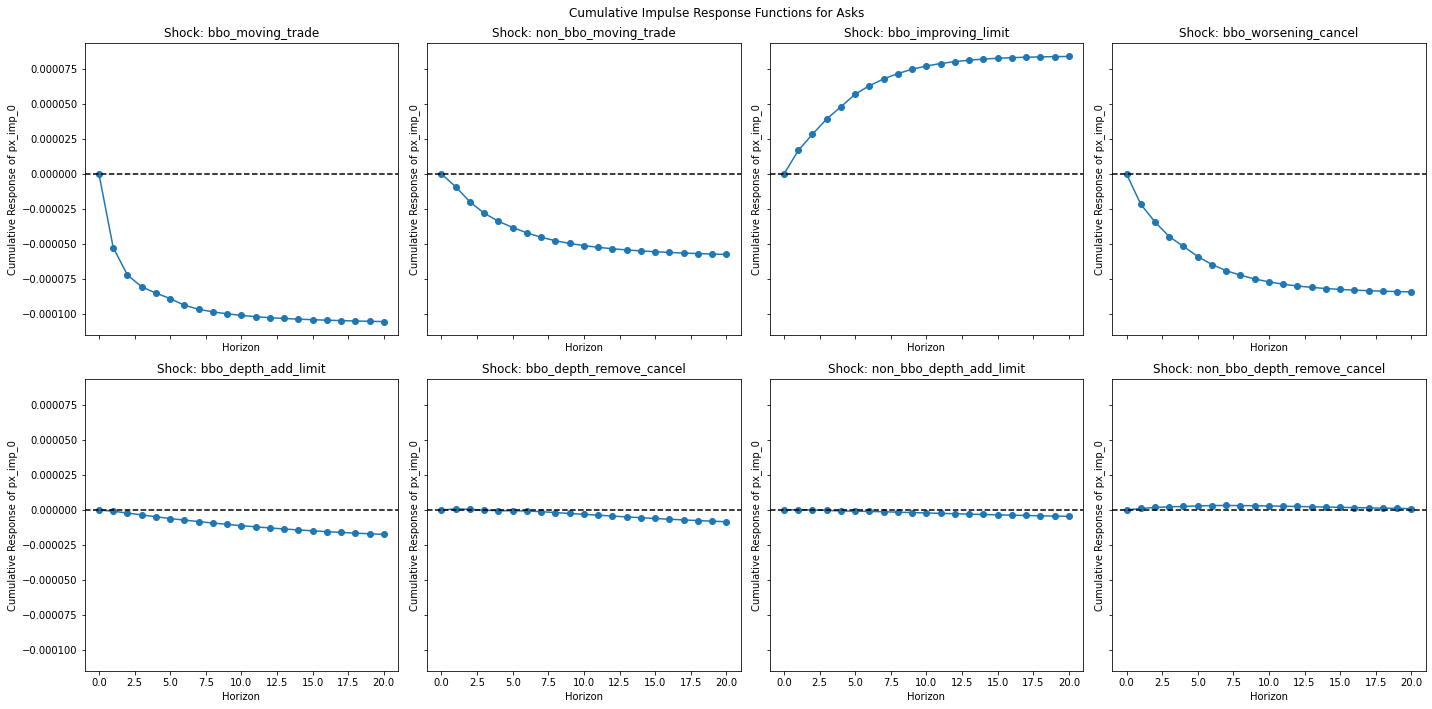

In [12]:
df = pd.read_parquet('/data/workspace_files/val_nov/first_week_df.parquet')
tracker['B']['first_week_nov'] = IRF(df, 'B', 'first_week_nov')
tracker['A']['first_week_nov'] = IRF(df, 'A', 'first_week_nov')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

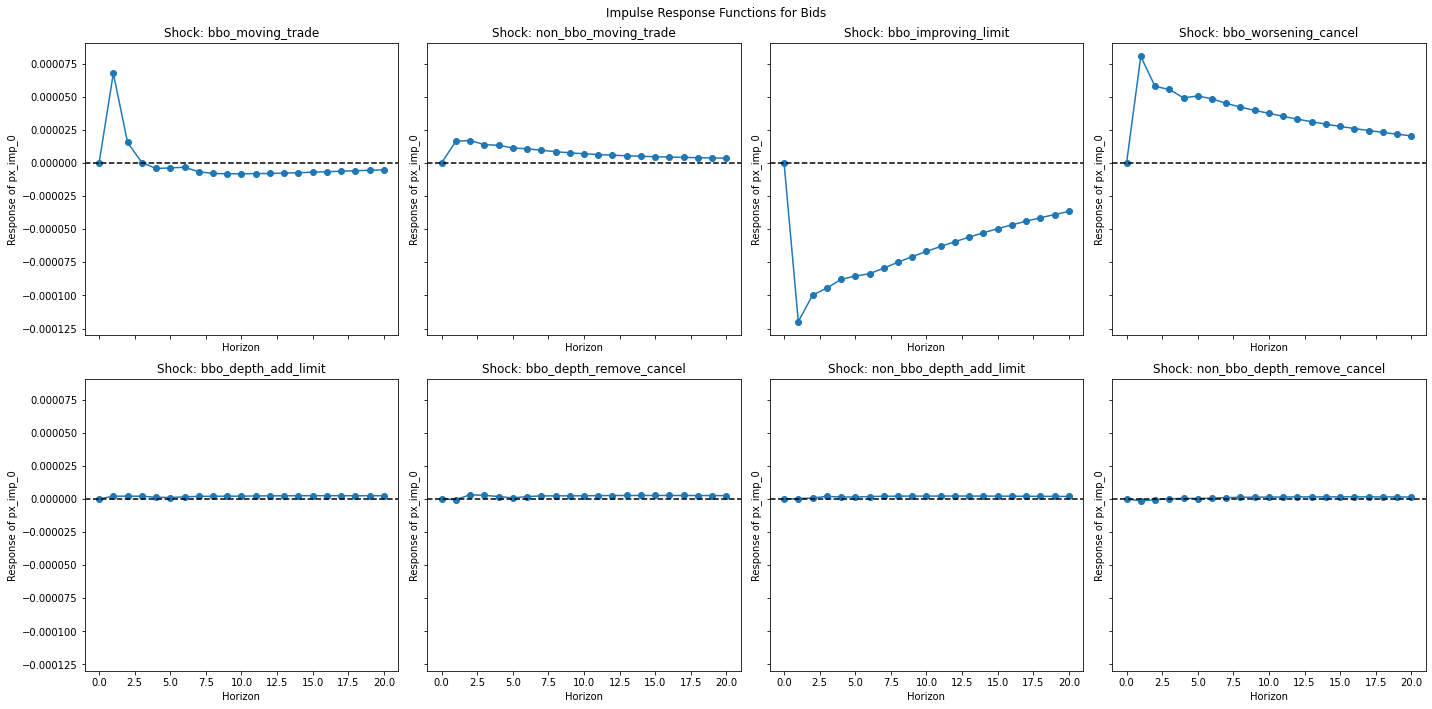

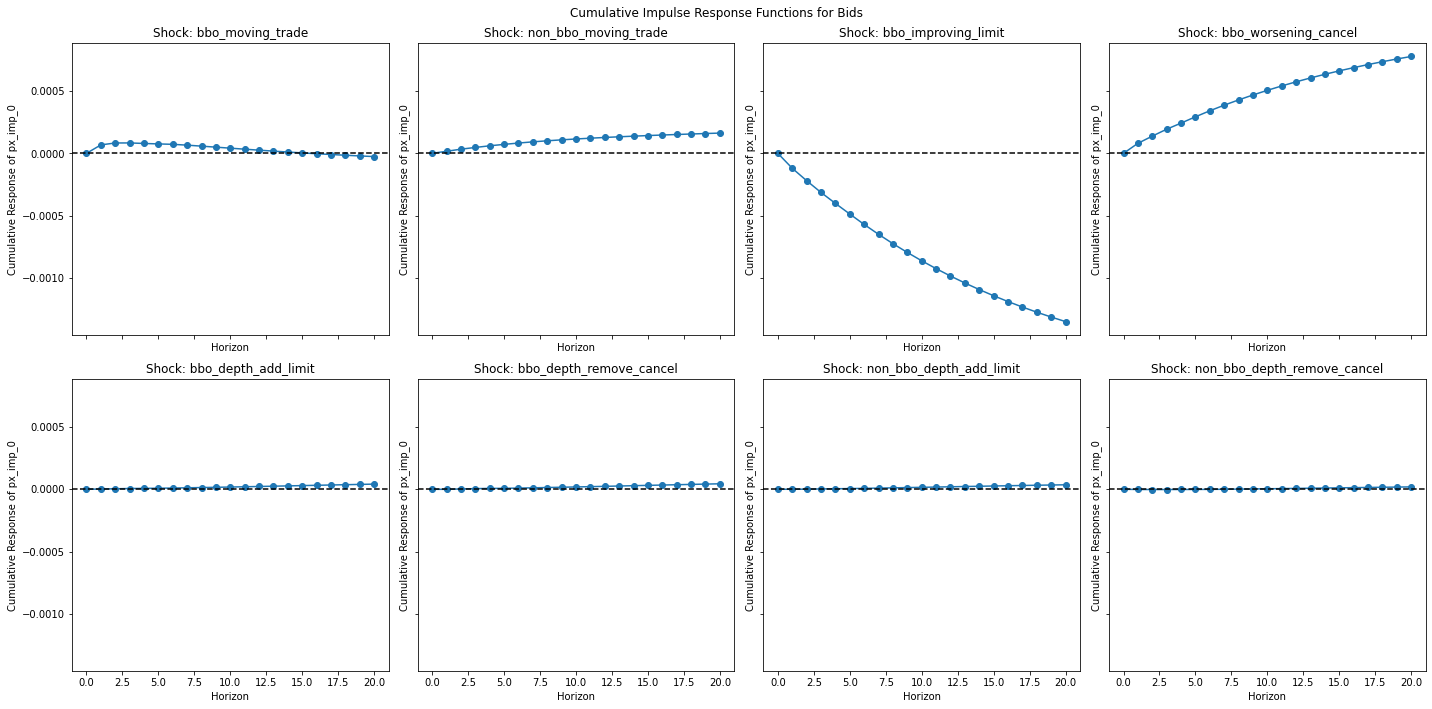

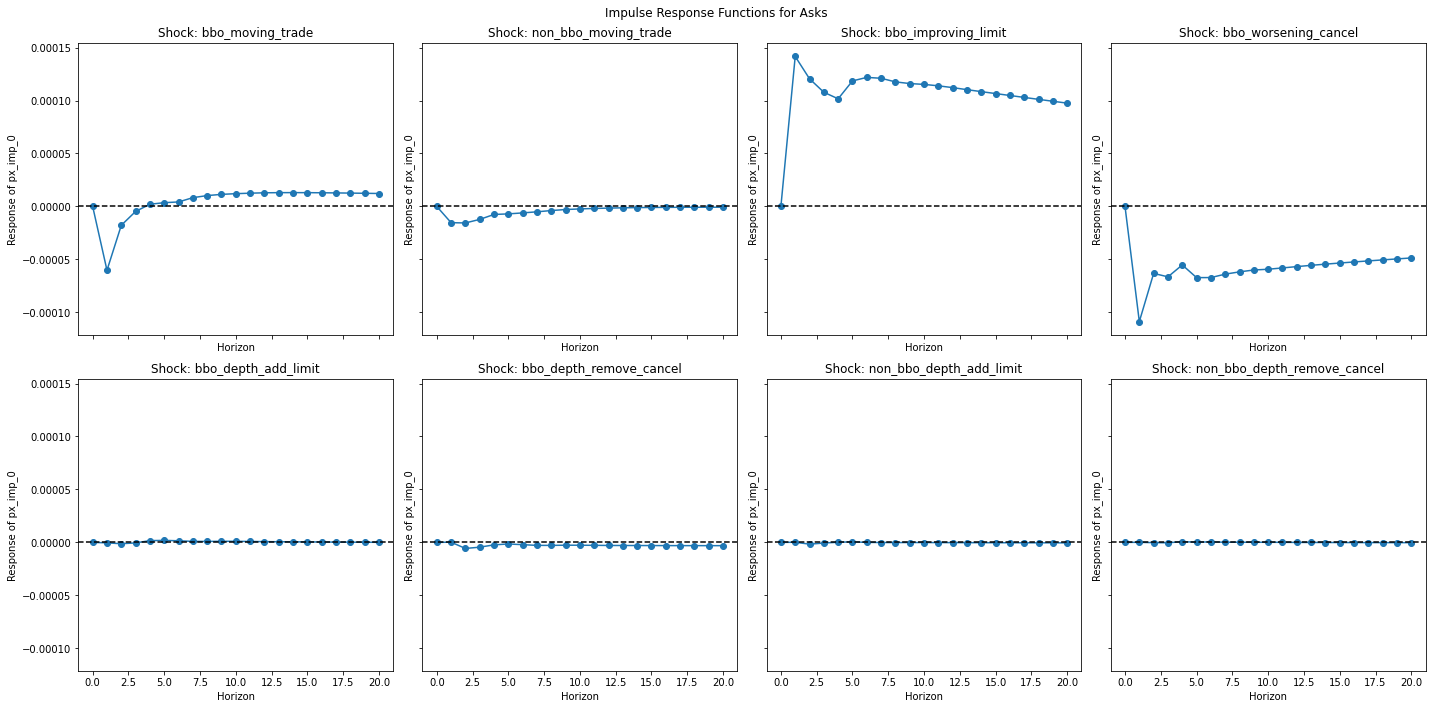

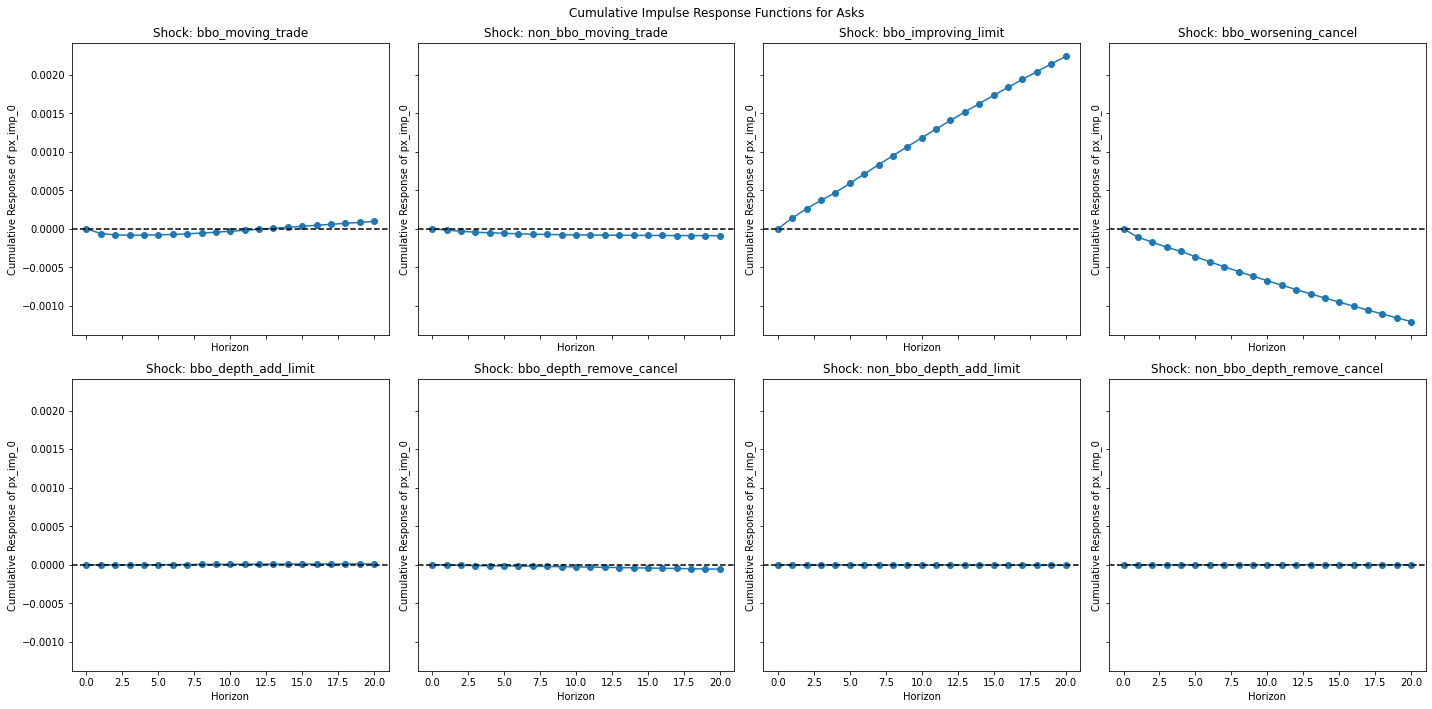

In [13]:
df = pd.read_parquet('/data/workspace_files/train_nov/second_week_df.parquet')
tracker['B']['second_week_nov'] = IRF(df, 'B', 'second_week_nov')
tracker['A']['second_week_nov'] = IRF(df, 'A', 'second_week_nov')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

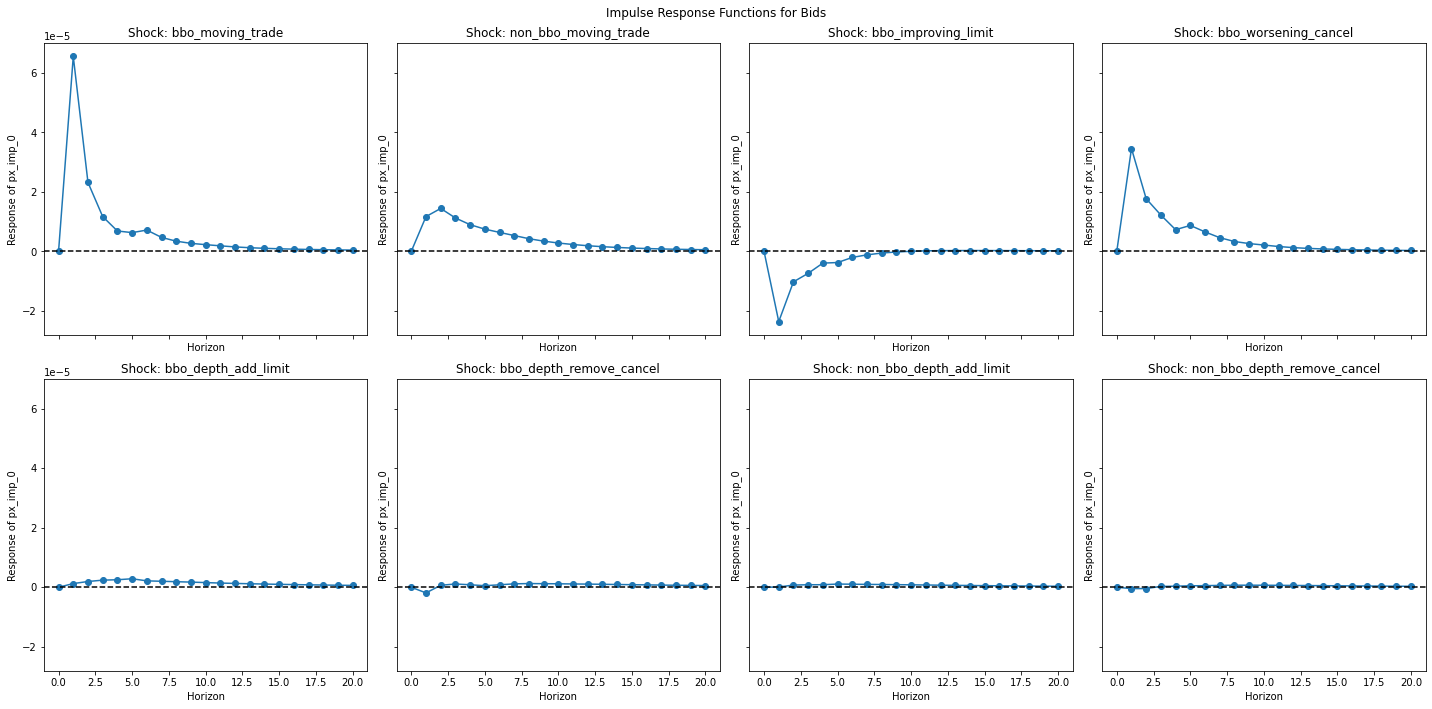

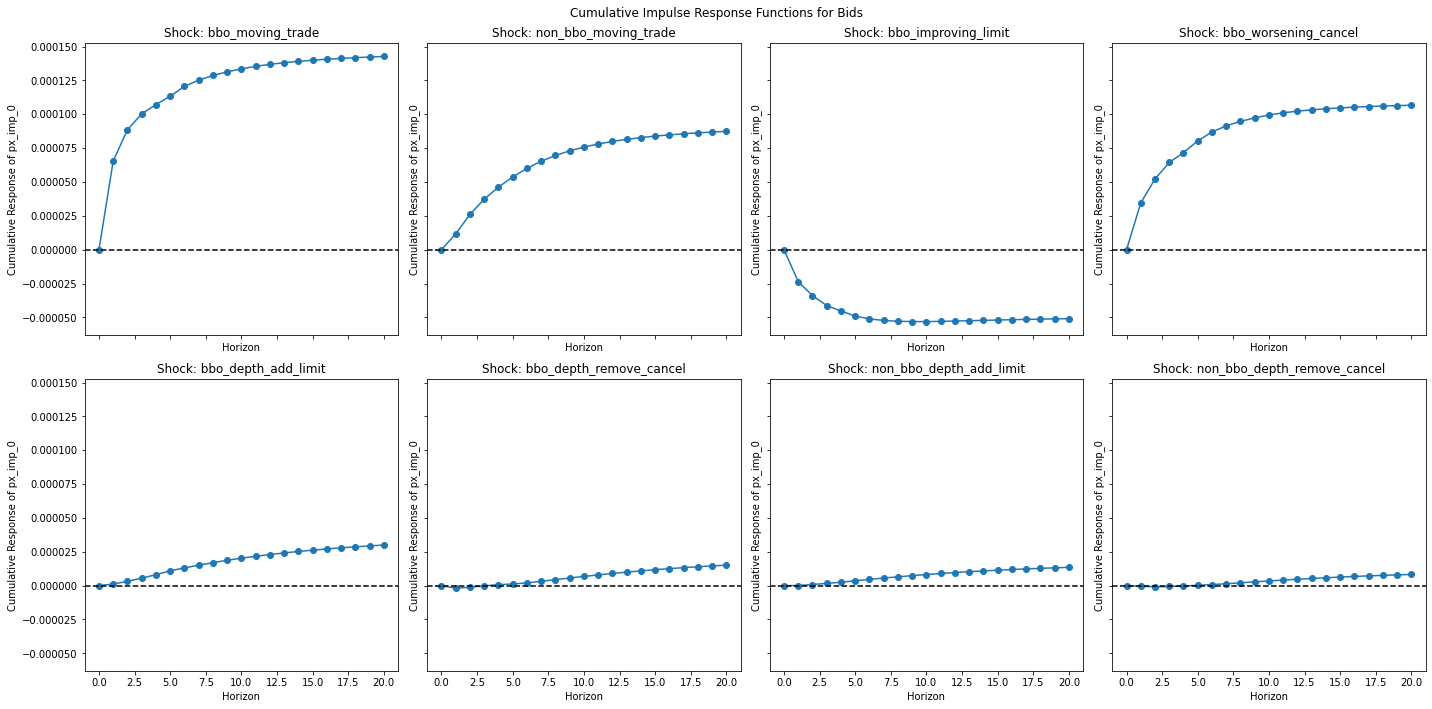

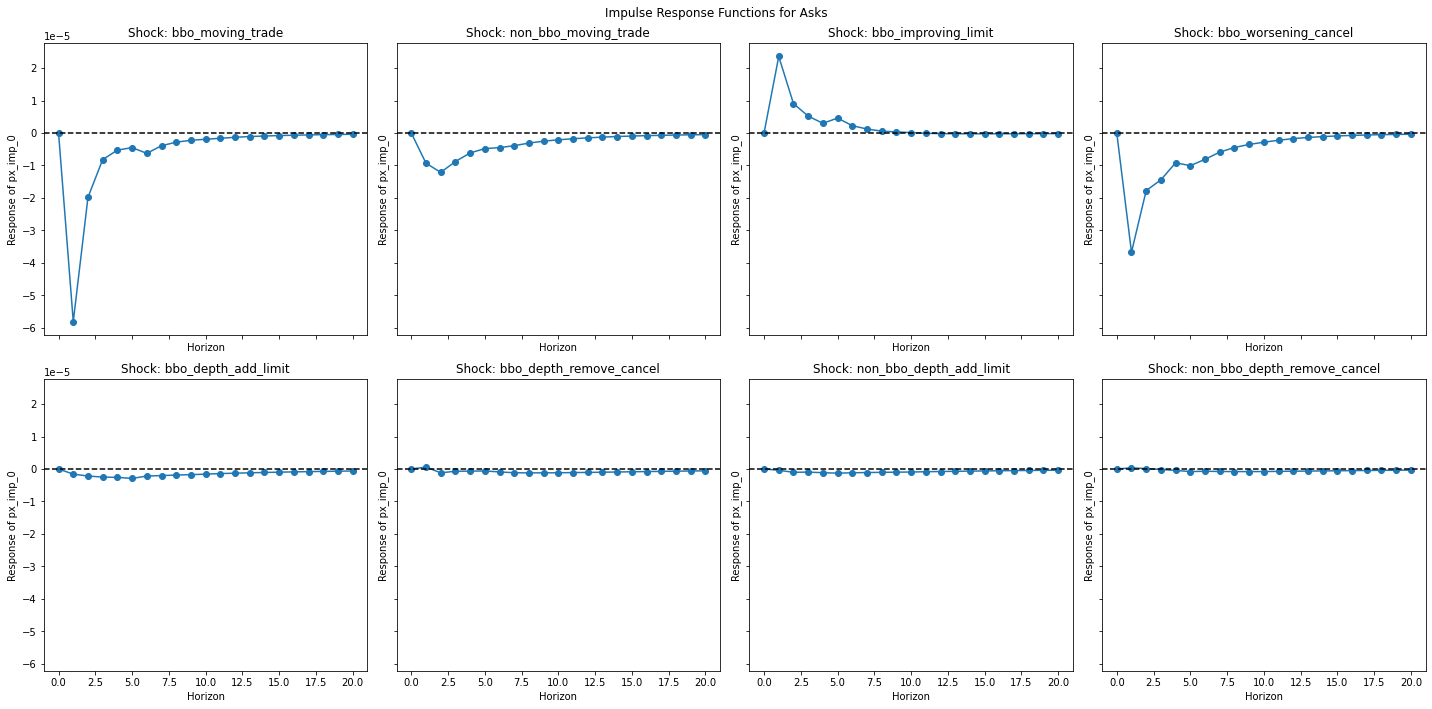

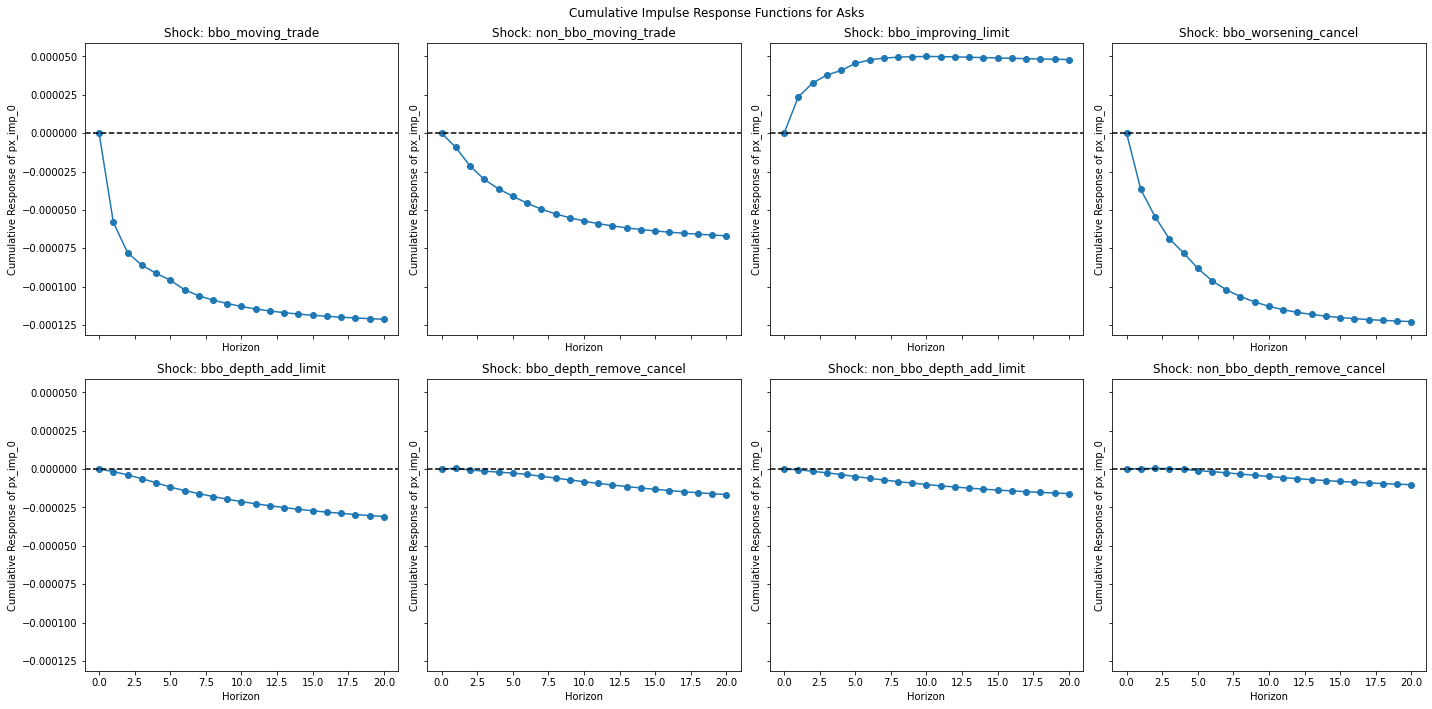

In [14]:
df = pd.read_parquet('/data/workspace_files/val_nov/third_week_df.parquet')
tracker['B']['third_week_nov'] = IRF(df, 'B', 'third_week_nov')
tracker['A']['third_week_nov'] = IRF(df, 'A', 'third_week_nov')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

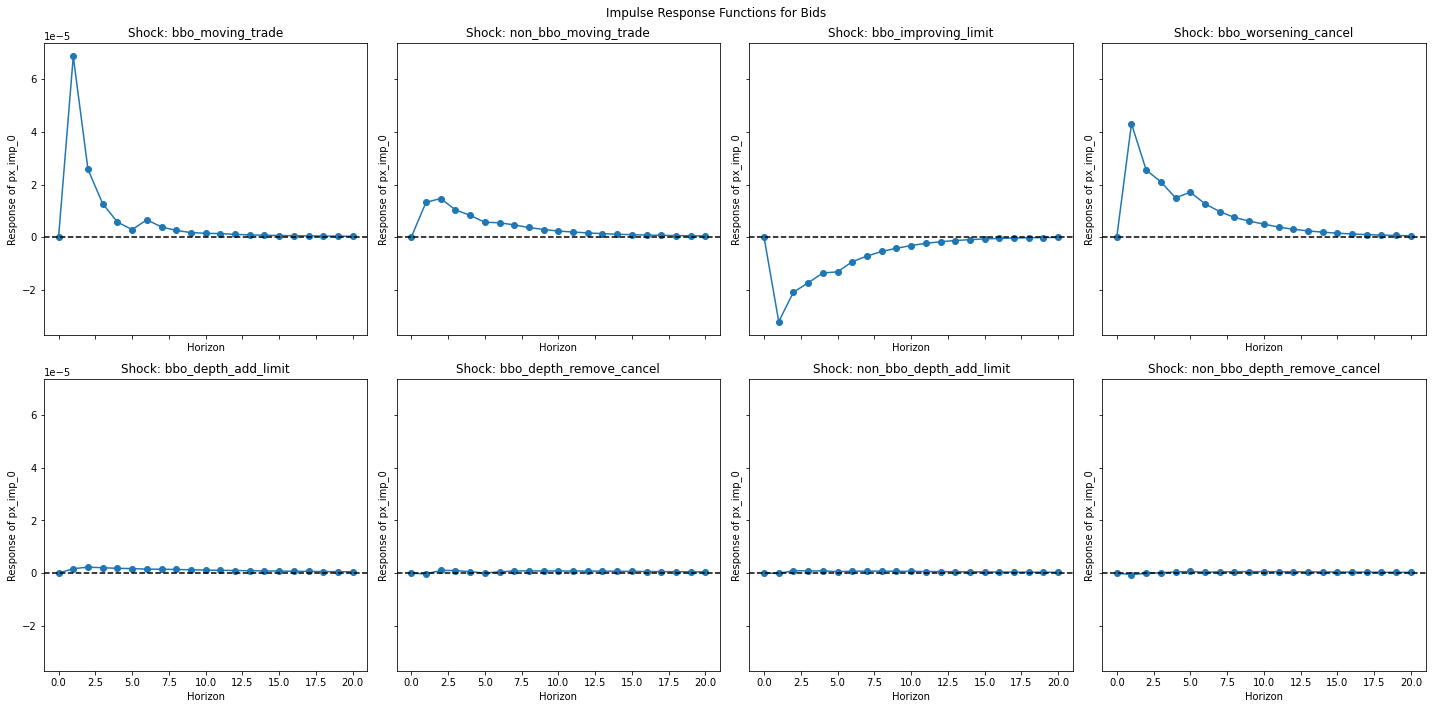

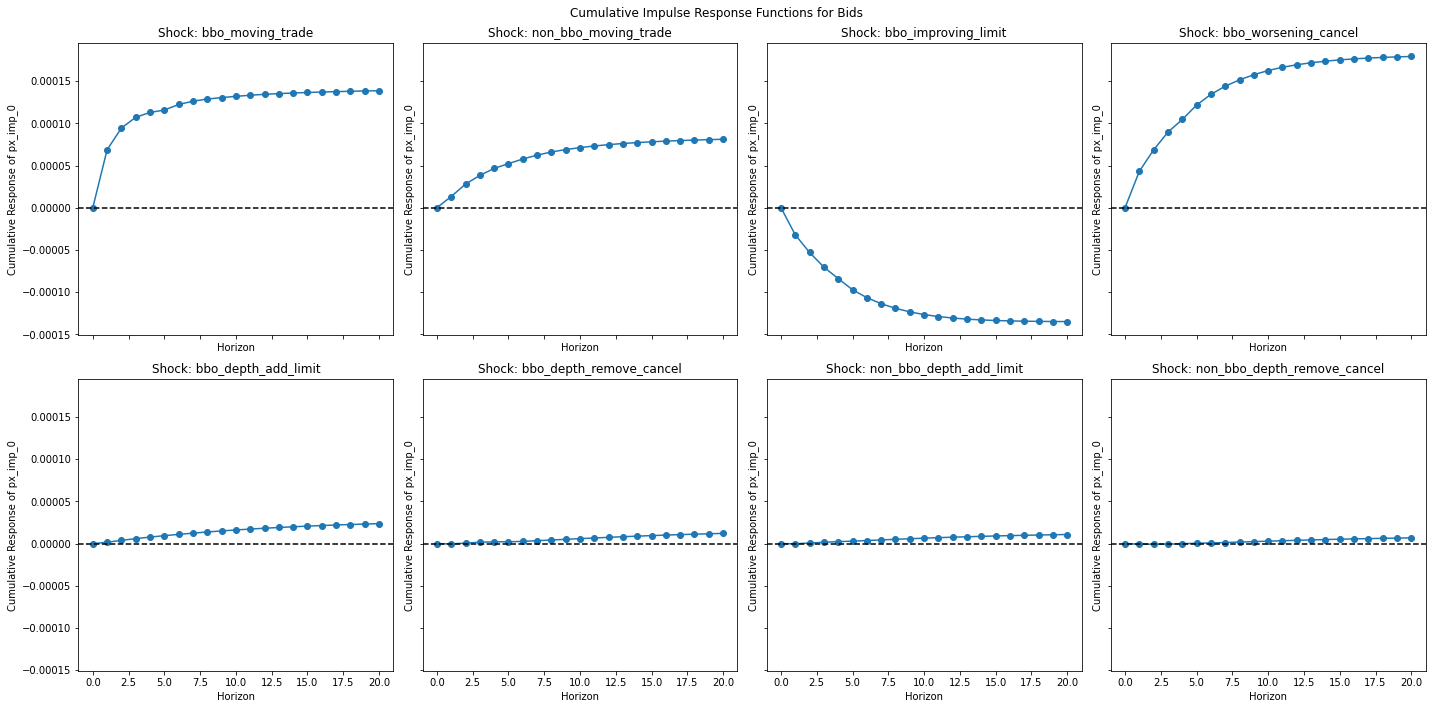

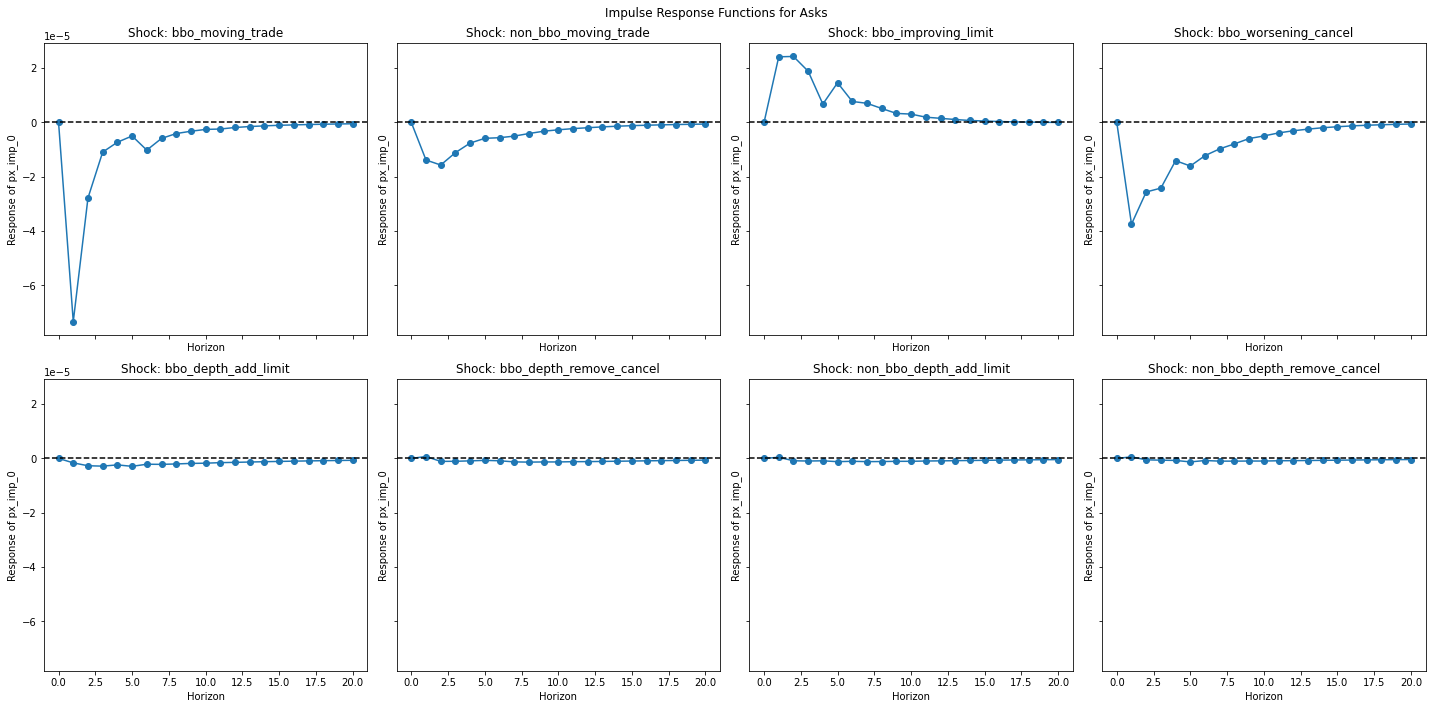

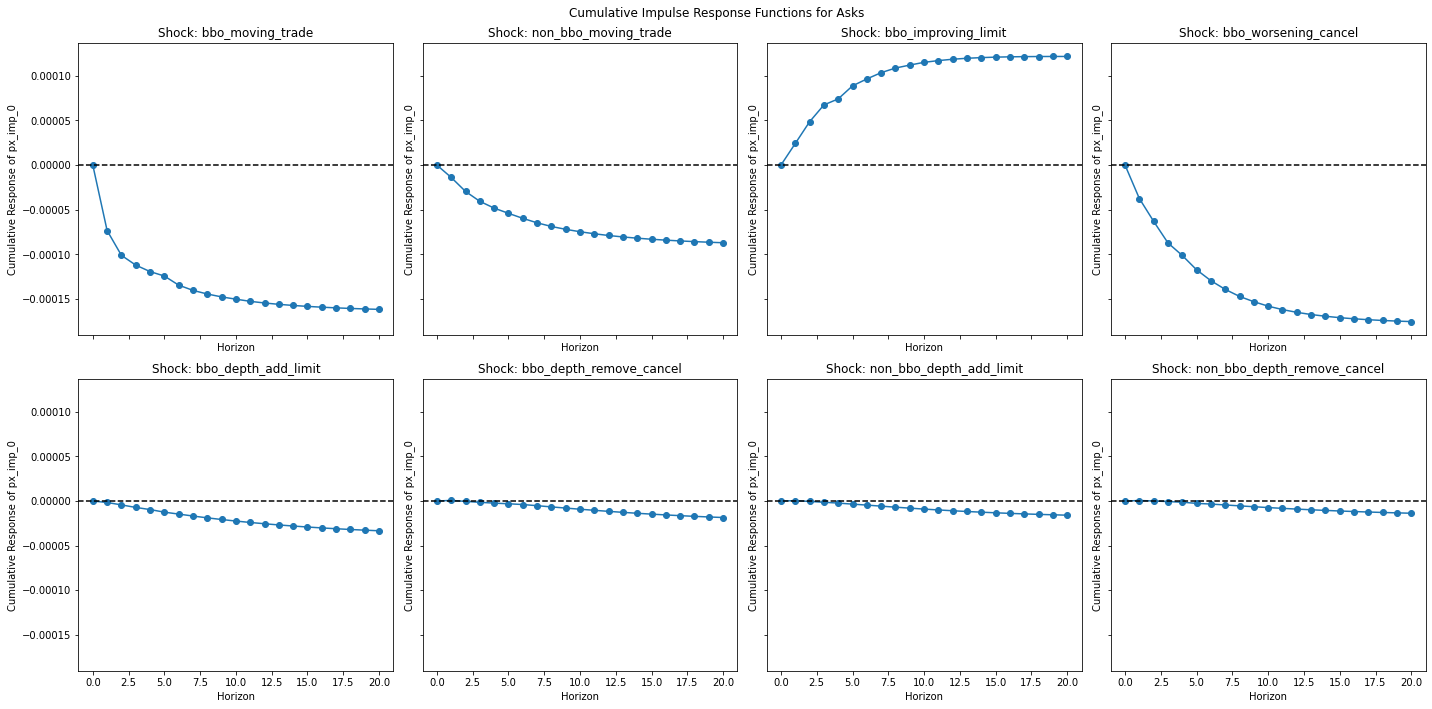

In [15]:
df = pd.read_parquet('/data/workspace_files/train_nov/fourth_week_df.parquet')
tracker['B']['fourth_week_nov'] = IRF(df, 'B', 'fourth_week_nov')
tracker['A']['fourth_week_nov'] = IRF(df, 'A', 'fourth_week_nov')

In [17]:
tracker['B']['mean'] = {}
tracker['A']['mean'] = {}

tracker['B']['mean']['bbo_moving_trade'] = 0
tracker['B']['mean']['non_bbo_moving_trade'] = 0
tracker['B']['mean']['bbo_improving_limit'] = 0
tracker['B']['mean']['bbo_worsening_cancel'] = 0
tracker['B']['mean']['bbo_depth_add_limit'] = 0
tracker['B']['mean']['non_bbo_depth_remove_cancel'] = 0

tracker['A']['mean']['bbo_moving_trade'] = 0
tracker['A']['mean']['non_bbo_moving_trade'] = 0
tracker['A']['mean']['bbo_improving_limit'] = 0
tracker['A']['mean']['bbo_worsening_cancel'] = 0
tracker['A']['mean']['bbo_depth_add_limit'] = 0
tracker['A']['mean']['non_bbo_depth_remove_cancel'] = 0

for k in tracker['B'].keys():
    if k == 'second_week_nov':
        continue
    tracker['B']['mean']['bbo_moving_trade'] += tracker['B'][k]['bbo_moving_trade']
    tracker['B']['mean']['non_bbo_moving_trade'] += tracker['B'][k]['non_bbo_moving_trade']
    tracker['B']['mean']['bbo_improving_limit'] += tracker['B'][k]['bbo_improving_limit']
    tracker['B']['mean']['bbo_worsening_cancel'] += tracker['B'][k]['bbo_worsening_cancel']
    tracker['B']['mean']['bbo_depth_add_limit'] += tracker['B'][k]['bbo_depth_add_limit']
    tracker['B']['mean']['non_bbo_depth_remove_cancel'] += tracker['B'][k]['non_bbo_depth_remove_cancel']

    tracker['A']['mean']['bbo_moving_trade'] += tracker['B'][k]['bbo_moving_trade']
    tracker['A']['mean']['non_bbo_moving_trade'] += tracker['B'][k]['non_bbo_moving_trade']
    tracker['A']['mean']['bbo_improving_limit'] += tracker['B'][k]['bbo_improving_limit']
    tracker['A']['mean']['bbo_worsening_cancel'] += tracker['B'][k]['bbo_worsening_cancel']
    tracker['A']['mean']['bbo_depth_add_limit'] += tracker['B'][k]['bbo_depth_add_limit']
    tracker['A']['mean']['non_bbo_depth_remove_cancel'] += tracker['B'][k]['non_bbo_depth_remove_cancel']

tracker['B']['mean']['bbo_moving_trade'] /= (len(tracker['B'].keys()) - 1)
tracker['B']['mean']['non_bbo_moving_trade'] /= (len(tracker['B'].keys()) - 1)
tracker['B']['mean']['bbo_improving_limit'] /= (len(tracker['B'].keys()) - 1)
tracker['B']['mean']['bbo_worsening_cancel'] /= (len(tracker['B'].keys()) - 1)
tracker['B']['mean']['bbo_depth_add_limit'] /= (len(tracker['B'].keys()) - 1)
tracker['B']['mean']['non_bbo_depth_remove_cancel'] /= (len(tracker['B'].keys()) - 1)

tracker['A']['mean']['bbo_moving_trade'] /= (len(tracker['B'].keys()) - 1)
tracker['A']['mean']['non_bbo_moving_trade'] /= (len(tracker['B'].keys()) - 1)
tracker['A']['mean']['bbo_improving_limit'] /= (len(tracker['B'].keys()) - 1)
tracker['A']['mean']['bbo_worsening_cancel'] /= (len(tracker['B'].keys()) - 1)
tracker['A']['mean']['bbo_depth_add_limit'] /= (len(tracker['B'].keys()) - 1)
tracker['A']['mean']['non_bbo_depth_remove_cancel'] /= (len(tracker['B'].keys()) - 1)

In [18]:
tracker['B']['mean']

{'bbo_moving_trade': 0.00020030433597179064,
 'non_bbo_moving_trade': 0.00012378402875880913,
 'bbo_improving_limit': -0.00020470738136681534,
 'bbo_worsening_cancel': 0.00023081752429069844,
 'bbo_depth_add_limit': 4.42795009981487e-05,
 'non_bbo_depth_remove_cancel': 5.941382494923978e-06}

In [19]:
tracker['A']['mean']

{'bbo_moving_trade': 0.00030045650395768596,
 'non_bbo_moving_trade': 0.0001856760431382137,
 'bbo_improving_limit': -0.000307061072050223,
 'bbo_worsening_cancel': 0.00034622628643604767,
 'bbo_depth_add_limit': 6.641925149722305e-05,
 'non_bbo_depth_remove_cancel': 8.912073742385969e-06}

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


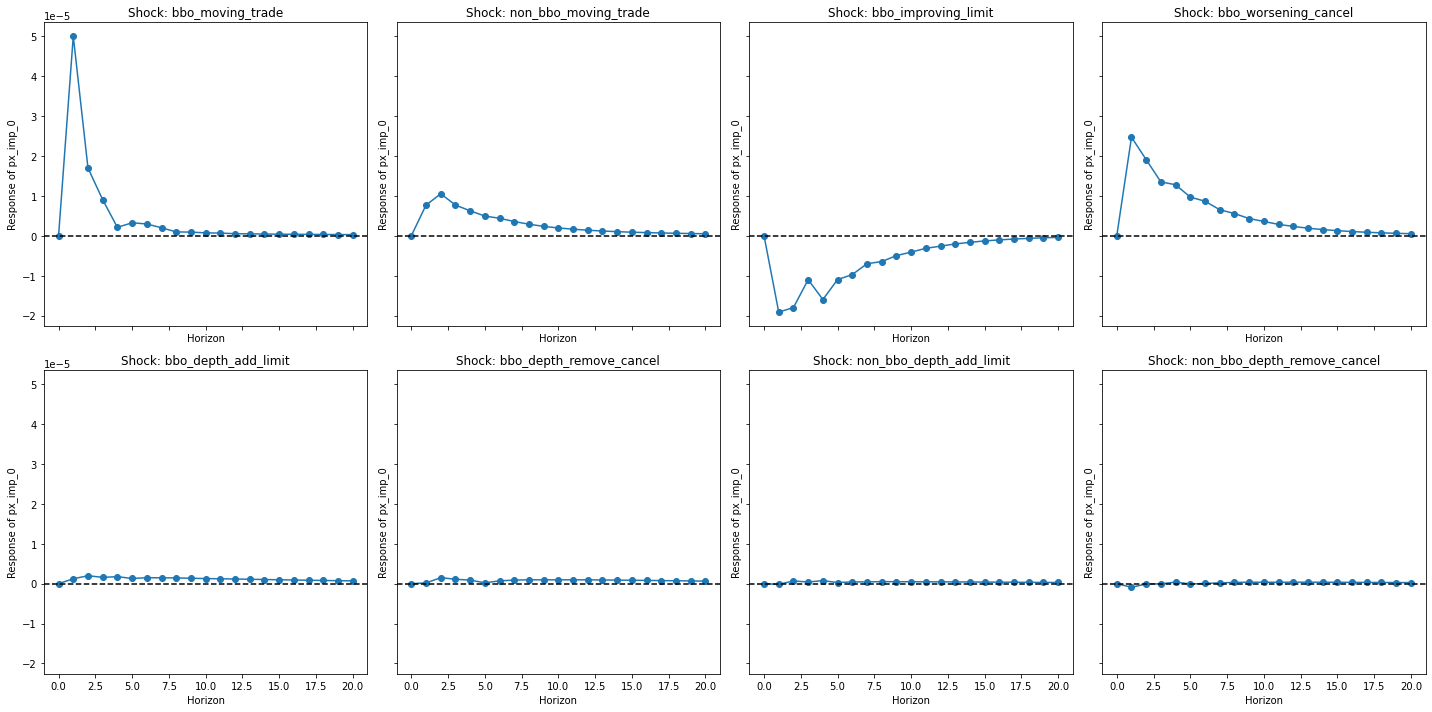

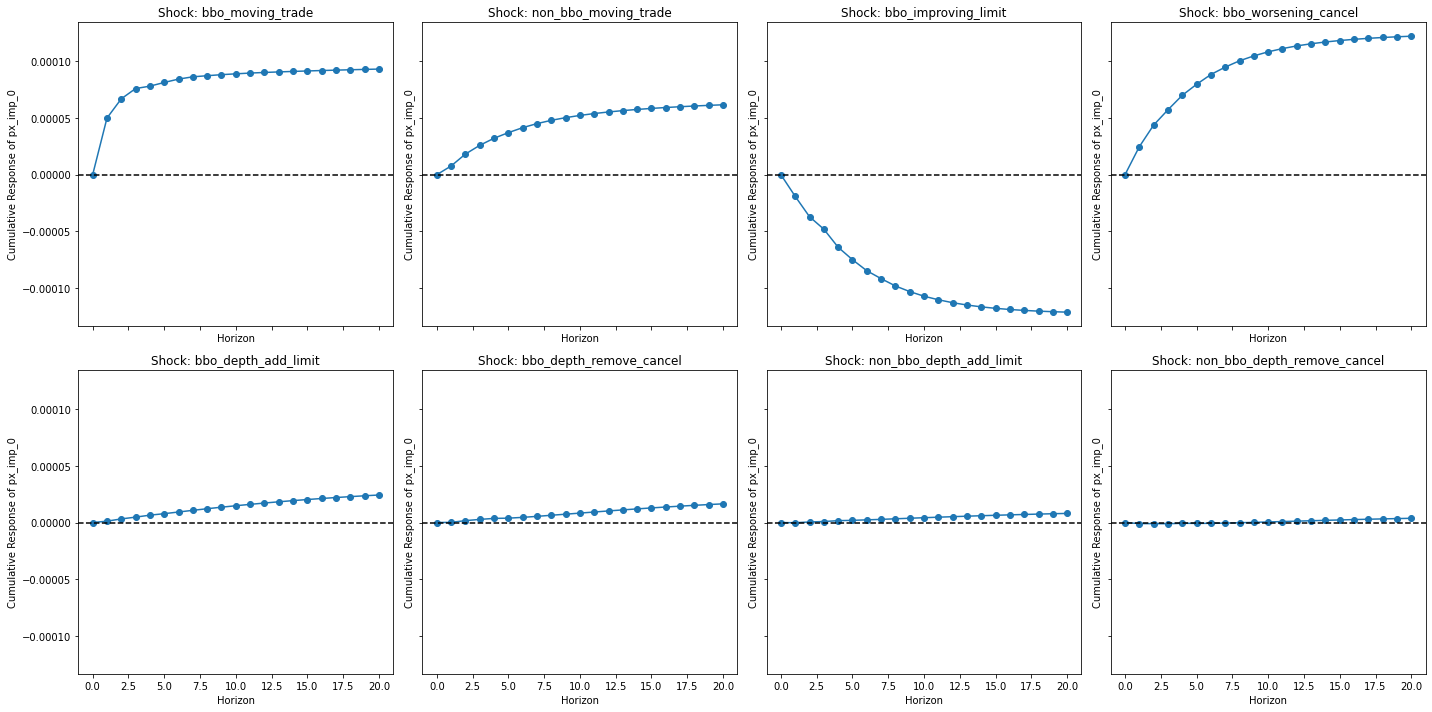

In [60]:
# Sandbox

# Load and prepare data
df = pd.read_parquet('/data/workspace_files/train_oct/third_week_df.parquet')
df.index = pd.to_datetime(df['ts_event'])
df = df[['side', 'px_imp_0', 'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
         'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
         'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel']]
# df['px_imp_0'] = np.abs(df['px_imp_0'])
df = df[df['side'] == 'B']
df = df.drop(columns='side')

# Create and fit the VAR model (using 5 lags for this example)
model = VAR(df)
results = model.fit(5)

# Compute the impulse response function for 20 periods ahead
irf = results.irf(20)
irf_array = irf.irfs  # shape: (steps+1, n_vars, n_vars)
steps = np.arange(irf_array.shape[0])

# Identify the target variable and its index
target_variable = 'px_imp_0'
target_index = results.names.index(target_variable)

# Create a list of shock indices (and names) excluding the target variable
shock_list = [(i, name) for i, name in enumerate(results.names) if i != target_index]

# Create a 2x4 subplot grid (for 8 shocks)
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Loop over each shock variable and plot the response of px_imp_0
for ax, (shock_index, shock_name) in zip(axs, shock_list):
    response = irf_array[:, target_index, shock_index]
    ax.plot(steps, response, marker='o')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f'Shock: {shock_name}')
    ax.set_xlabel("Horizon")
    ax.set_ylabel(f"Response of {target_variable}")

plt.tight_layout()
plt.show()

# Create a 2x4 subplot grid (for 8 shocks)
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

result = {}

# Loop over each shock variable and plot the response of px_imp_0
for ax, (shock_index, shock_name) in zip(axs, shock_list):
    response = irf_array[:, target_index, shock_index].cumsum()
    result[shock_name] = response[-1]
    ax.plot(steps, response, marker='o')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f'Shock: {shock_name}')
    ax.set_xlabel("Horizon")
    ax.set_ylabel(f"Cumulative Response of {target_variable}")

plt.tight_layout()
plt.show()

In [61]:
result

{'bbo_moving_trade': 9.321549754597356e-05,
 'non_bbo_moving_trade': 6.170202086530826e-05,
 'bbo_improving_limit': -0.00012132316528830688,
 'bbo_worsening_cancel': 0.00012223480163934573,
 'bbo_depth_add_limit': 2.430420437690223e-05,
 'bbo_depth_remove_cancel': 1.6507268411363742e-05,
 'non_bbo_depth_add_limit': 8.062035580858794e-06,
 'non_bbo_depth_remove_cancel': 3.7538948878071453e-06}

### Data Definitions

In [5]:
predictor_cols = ['bid', 'spread_minus', 'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
                  'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
                  'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 'non_bbo_deep_depth_add_limit',
                  'non_bbo_deep_depth_remove_cancel', 'bbo_depth_imbalance_minus', 
                  'non_bbo_depth_imbalance_minus', 'non_bbo_deep_depth_imbalance_minus', 
                  'bbo_queue_length_immbalance_minus', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6']

ob_features = ['bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
                   'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
                   'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 
                   'non_bbo_deep_depth_add_limit', 'non_bbo_deep_depth_remove_cancel']

for feat in ob_features:
    for r in range(1, 3):
        col_name = f'{feat}_{r}'
        predictor_cols.append(col_name)

In [6]:
eval_pairs = [('/data/workspace_files/train_oct/first_week_df.parquet', '/data/workspace_files/val_oct/second_week_df.parquet'),
              ('/data/workspace_files/train_oct/third_week_df.parquet', '/data/workspace_files/val_oct/fourth_week_df.parquet'),
              ('/data/workspace_files/train_oct/fifth_week_df.parquet', '/data/workspace_files/val_nov/first_week_df.parquet'),
              ('/data/workspace_files/train_nov/second_week_df.parquet', '/data/workspace_files/val_nov/third_week_df.parquet')]

### Regression Analysis and Final Model Evaluation

First, run a regression on full data. Then, try classifying first before regressing.

In [7]:
def vanilla_regression(predictor_cols, target):
    val_errors = []
    val_fit = []

    for i, pair in enumerate(eval_pairs):
        print(i)
        df_train = pd.read_parquet(pair[0])
        X_train = df_train[predictor_cols]
        y_train = df_train[target]

        df_val = pd.read_parquet(pair[1])
        X_val = df_val[predictor_cols]
        y_val = df_val[target]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        mod = LinearRegression().fit(X_train, y_train)
        val_preds = mod.predict(X_val)

        val_mse = mean_squared_error(y_val, val_preds)
        val_r2 = r2_score(y_val, val_preds)
        val_errors.append(val_mse)
        val_fit.append(val_r2)

    return val_errors, val_fit

In [11]:
reg_errors, reg_fits = vanilla_regression(predictor_cols, 'px_imp_5')

0
1
2
3


In [12]:
reg_fits

[0.009047126538788919,
 0.009105158314244188,
 0.008187912819198617,
 -0.001089144217475635]

In [8]:
df1 = pd.read_parquet('/data/workspace_files/val_nov/third_week_df.parquet')
df2 = pd.read_parquet('/data/workspace_files/train_nov/fourth_week_df.parquet')
df = pd.concat([df1, df2])

X = df[predictor_cols]
y = df['px_imp_5']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X = sm.add_constant(X)

final_mod = sm.OLS(y, X).fit(covtype='HC3')
final_mod.summary()

OSError: OSError: [Errno 5] Input/output error: '/data/workspace_files/val_nov/third_week_df.parquet'

In [15]:
with open('/data/workspace_files/Models/OLS/final_mod.pkl', 'wb') as file:
    pickle.dump(final_mod, file)

In [1]:
with open('/data/workspace_files/Models/OLS/final_mod.pkl', 'rb') as file:
    final_mod = pickle.load(file)

NameError: NameError: name 'pickle' is not defined

In [ ]:
df1 = pd.read_parquet('/data/workspace_files/test_dec/test_weeks_dec.parquet')

X_test = df[predictor_cols]
y_test = df['px_imp_5']

X_test_scaled = scaler.transform(X_test)
X_test = pd.Dataframe(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test = sm.add_constant(X_test)

y_preds = final_mod.predict(X_test)

final_r2 = r2_score(y_test, y_preds)
final_mse = mean_squared_error(y_test, y_preds)

print(f'R^2: {final_r2}')
print(f'MSE: {final_mse}')